In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Add
from keras.utils.vis_utils import plot_model

from numpy.linalg import norm
import pandas as pd

import sklearn.metrics

from keras import regularizers as l 

from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, datasets
from itertools import cycle, islice

import os

from matplotlib.ticker import FormatStrFormatter

import time

In [ ]:
print(os.getcwd())

/content


In [ ]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados')
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados


In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
def twospirals(n_points, noise=1.2):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 450 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [ ]:
def load_data():
  np.random.seed(2023)
  n_samples = 3000
  X, Y = twospirals(n_samples//2)
  Y = [int(label) for label in Y]
  Y = np.array(Y)
  # Figuras
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  colors = ['#ff5271' if label == 1 else '#5271ff' for label in Y]
  plt.scatter(X[:, 0], X[:, 1], s=100, alpha = 0.8,
              c = colors)
  plt.axis('off')
  plt.tight_layout()
  nameFile = 'twoSpiral.pdf'
  plt.savefig(nameFile) 
  plt.show()

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, 
                                                    random_state=1, stratify=Y)
 
  sc = StandardScaler()
  sc.fit(X_train)
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

  print(f'Conjunto de datos cargados')
  print(f'Tamaño datos de entrenamiento {X_train.shape}')
  print(f'Tamaño datos de test {X_test.shape}')
  print(f'Datos por cada etiqueta en X train {np.bincount(y_train)}')
  return X_train, X_test, y_train, y_test

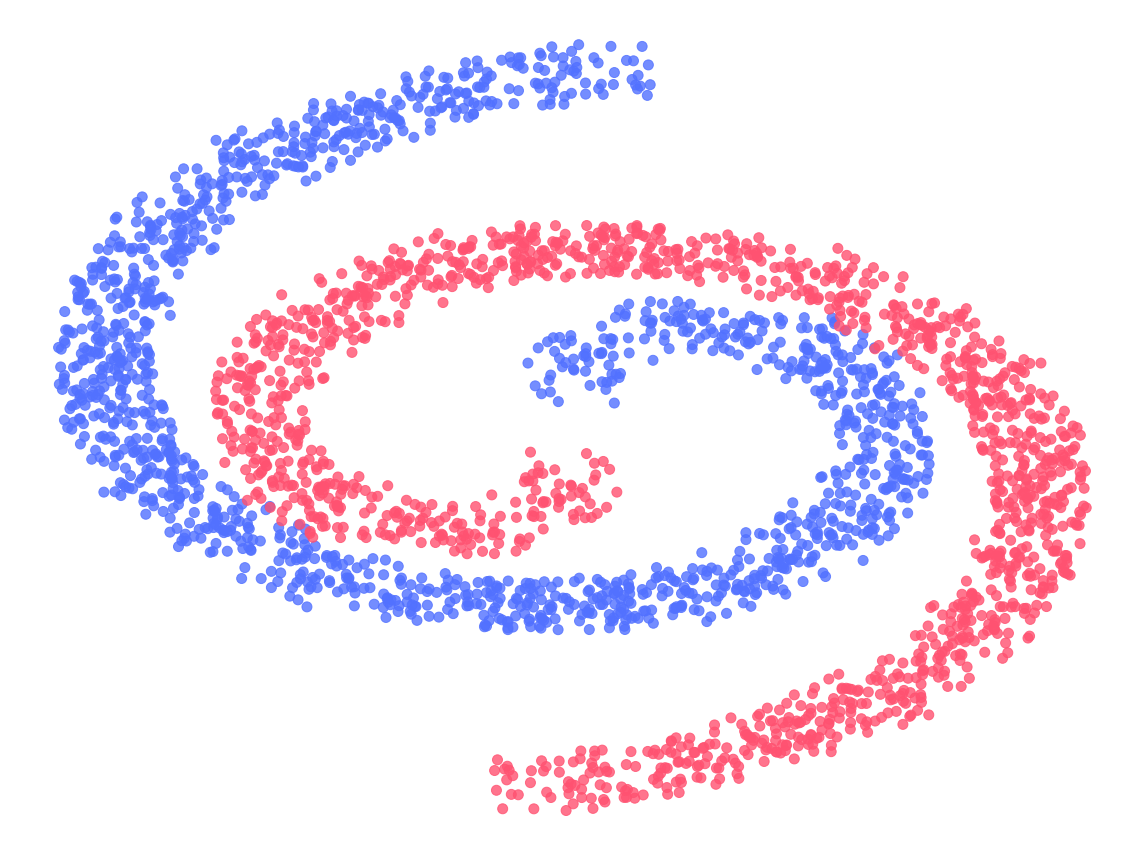

Conjunto de datos cargados
Tamaño datos de entrenamiento (1800, 2)
Tamaño datos de test (1200, 2)
Datos por cada etiqueta en X train [900 900]


In [ ]:
X_train, X_test, y_train, y_test = load_data()

## Modelo con $n$ saltos residuales

In [ ]:
def skip_conection(dense_input, n, regular_l):
  if n >= 2:
    resDense = Dense(10, activation ='tanh', kernel_regularizer=regular_l)(dense_input)
    return skip_conection(Add()([dense_input, resDense]), n-1, regular_l)
  resDenseo = Dense(10, activation ='tanh', kernel_regularizer=regular_l)(dense_input)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_model(n, regular_l):
  keras.backend.clear_session()
  inputs  = Input(shape=(2,))
  dense1  = Dense(10, activation  ='tanh', kernel_regularizer=regular_l)(inputs)
  
  skip_final = skip_conection(dense1, n, regular_l)

  outputs = Dense(1, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=100, shuffle=True):
        super().__init__()
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
        self.on_epoch_end()

    def __len__(self):
        return len(self.key_array)//self.batch_size

    def __getitem__(self, index):
        keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]
        x = np.asarray(self.images[keys], dtype=np.float32)
        y = np.asarray(self.labels[keys], dtype=np.float32)
      
        return x, y

    def on_epoch_end(self):
        if self.shuffle:
            self.key_array = np.random.permutation(self.key_array)

In [ ]:
generator = DataGenerator(images=X_train, labels=y_train, batch_size=50, shuffle=True)
n_batches = len(generator)
n_batches

36

In [ ]:
def lipschitz_bound(modelWeigts):
  numberLayers = len(modelWeigts)
  LipsBound = np.linalg.norm(modelWeigts[0], ord=2)     # Norma espectral (2) capa 1
  if LipsBound == 0: LipsBound = 1

  for rc in np.arange(2,numberLayers-2,2):              # En los indices de las capas residuales
    try: 
      LipsBound *= (1 + np.linalg.norm(modelWeigts[rc], ord=2))
    except:
      LipsBound *= 1
  
  LipsBound *= np.linalg.norm(modelWeigts[numberLayers-2], ord=2) # Capa de salida

  return  LipsBound

##  Funciones graficar 

In [ ]:
def graphGridAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1.0)
  plt.grid()
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.tight_layout()
  nameFile = 'presicionModelo' + str(skip) + 'G' +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()



def graphAcc(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, acc_train_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Precisión entrenamiento', lw = 3)
  plt.plot(epoch_vec, acc_val_mean_M0,  '#ff5271', 
           label='Precisión validación', linestyle = '-', marker = 'o', lw = 3)
  plt.fill_between(epoch_vec, acc_std_positive_M0, acc_std_negative_M0, 
                   label = r'$\sigma$ precisión entrenamiento',
                  alpha=0.2, color = '#5271ff')
  plt.fill_between(epoch_vec, acc_std_positive_val_M0, acc_std_negative_val_M0, 
                   label = r'$\sigma$ precisión validación',
                  alpha=0.2, color = '#ff5271')
  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'Precisión',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.ylim(top=1.0)
  plt.legend(fontsize=36,loc = 'lower right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  nameFile = 'presicionModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


In [ ]:
def graphGridLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                  label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  nameFile = 'cotaLipschitzModelo' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtiz(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, LB_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, LB_std_positive_M0, LB_std_negative_M0, 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$LB$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelo' + str(skip) +'.pdf'
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0), 
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  plt.grid()
  plt.tight_layout()
  nameFile = 'cotaLipschitzModelolog' + str(skip) + 'G' +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLipschtizlog(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, np.log10(LB_mean_M0), '#5271ff', linestyle = "-", marker = "o",
           label='Cota de Lipschitz', lw = 3)
  plt.fill_between(epoch_vec, np.log10(LB_std_positive_M0), np.log10(LB_std_negative_M0),
                   alpha=0.2, color = '#5271ff',
                   label = r'$\sigma$ cota de Lipschitz')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$\log_{10} (LB)$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'best')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  plt.ticklabel_format(axis = 'y')
  nameFile = 'cotaLipschitzModelolog' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

In [ ]:
def graphGridLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  plt.grid()
  nameFile = 'funcionPerdidaModelo' + str(skip) + 'G' + '.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()

def graphLoss(skip):
  fig = plt.figure(figsize=(16, 12))
  ax = plt.gca()
  ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.plot(epoch_vec, loss_mean_M0, '#5271ff', linestyle = "-", marker = "o",
           label='Perdida entrenamiento', lw = 3)
  plt.fill_between(epoch_vec, loss_std_positive_M0, loss_std_negative_M0, 
                  label = r'$\sigma$ perdida en entrenamiento', 
                   alpha=0.2, color = '#5271ff')
  plt.plot(epoch_vec, loss_mean_M0_val, '#ff5271', label='Perdida validación', 
           lw = 3, linestyle = '-', marker = 'o')
  plt.fill_between(epoch_vec, loss_std_positive_M0_val, loss_std_negative_M0_val, 
                  label = r'$\sigma$ perdida en validación',
                   alpha=0.2, color = '#ff5271')

  plt.xlabel('Época',fontsize=36)
  plt.ylabel(r'$l(y,\hat{y})$',fontsize=36)
  plt.xlim([1, n_epochs])
  plt.legend(fontsize=36,loc = 'upper right')
  plt.xticks(np.arange(0, n_epochs+1, step=10), fontsize=36)
  plt.yticks(fontsize=36)
  ##plt.ticklabel_format(axis = 'y', style = 'scientific')
  nameFile = 'funcionPerdidaModelo' + str(skip) +'.pdf'
  plt.tight_layout()
  plt.savefig(nameFile) 
  #plt.show()


## Entrenamiento conjunto de modelos validación cruzada k-fold - Entrenamiento Convencional

Modelo : 15 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
14
Tiempo total 24.468047618865967 en k-fold 1
14
Tiempo total 27.577580213546753 en k-fold 2
14
Tiempo total 24.13941216468811 en k-fold 3
14
Tiempo total 26.867840051651 en k-fold 4
14
Tiempo total 29.71745800971985 en k-fold 5


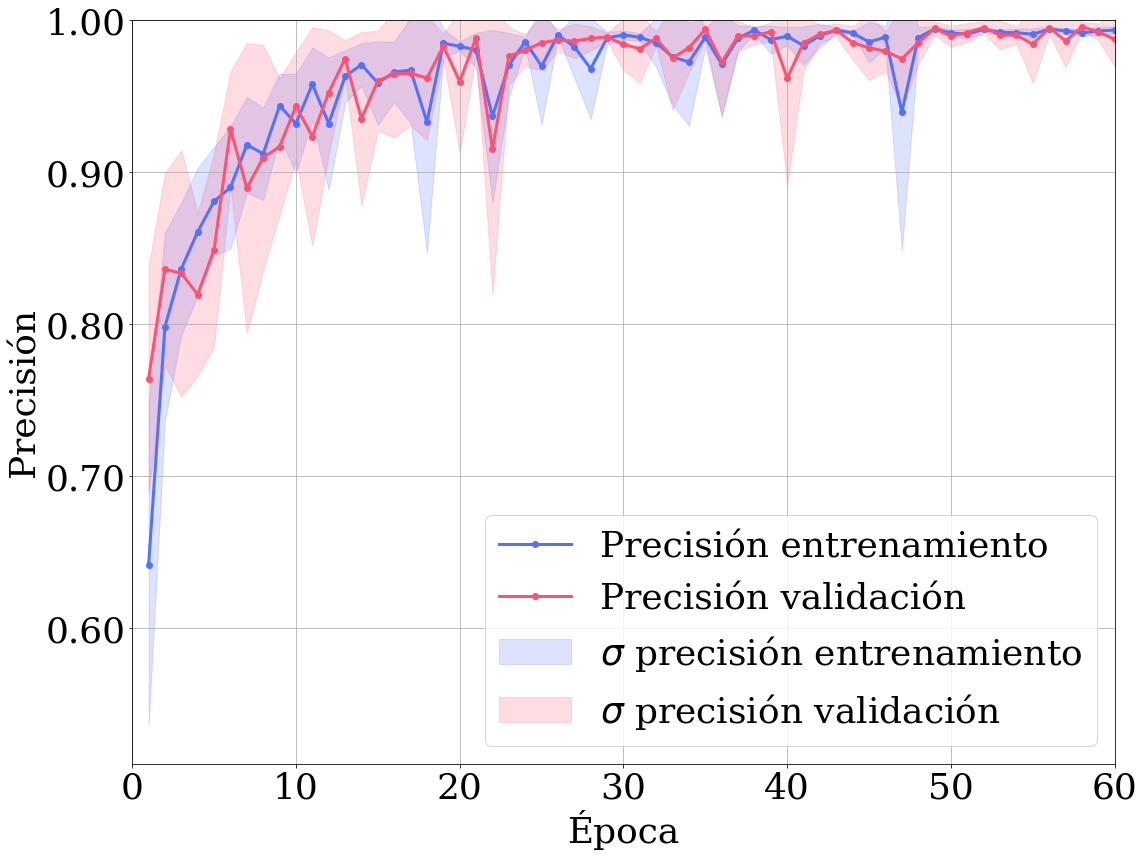

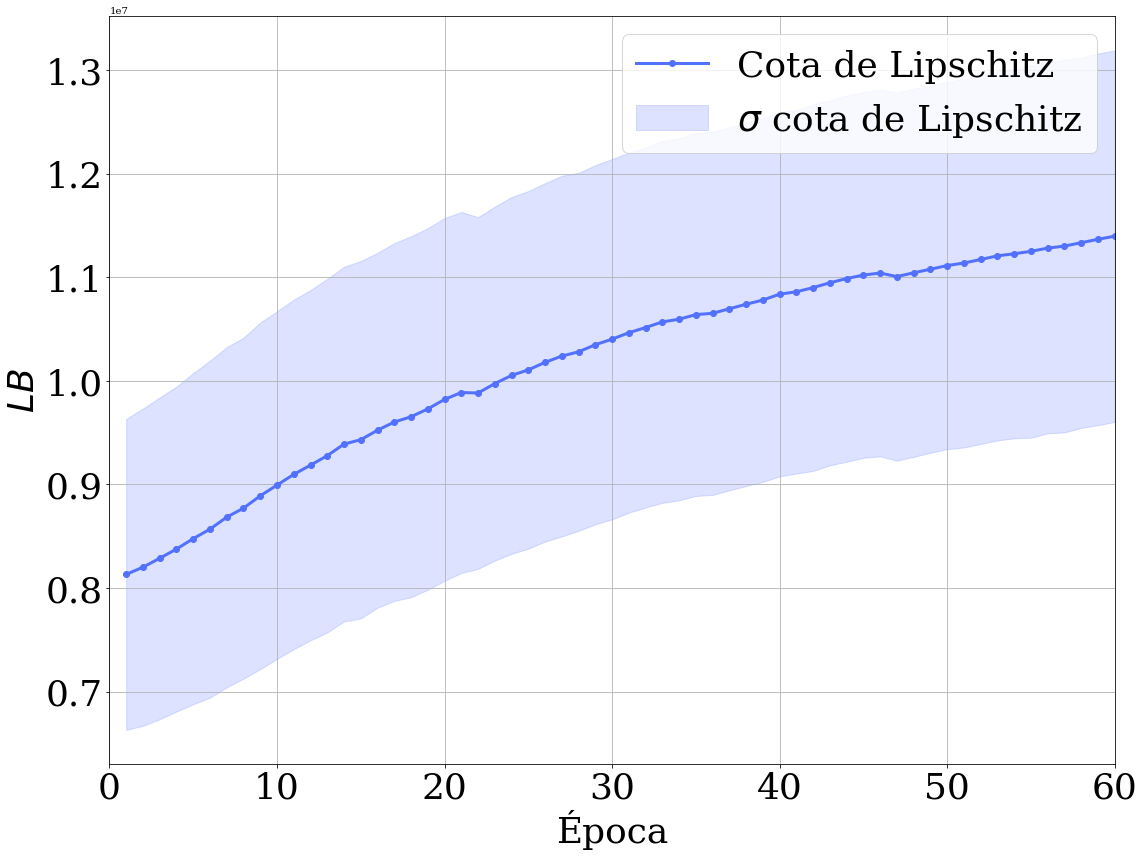

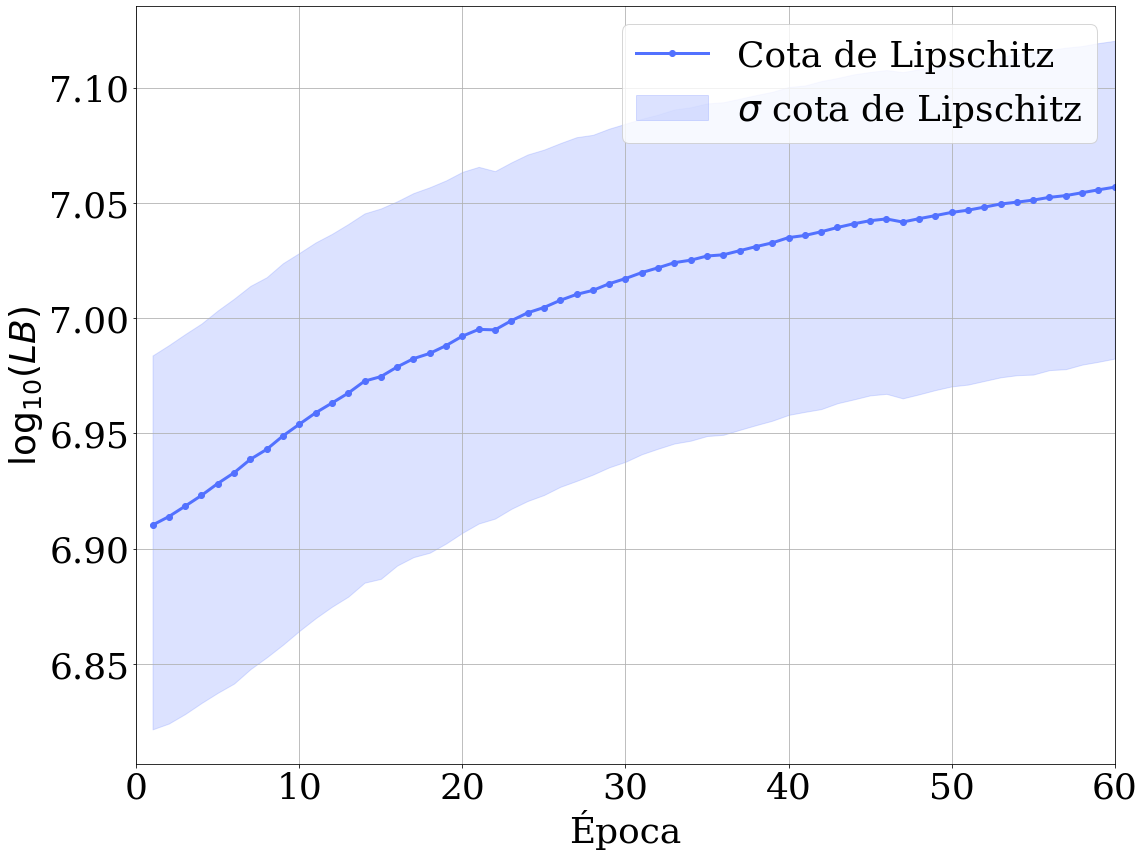

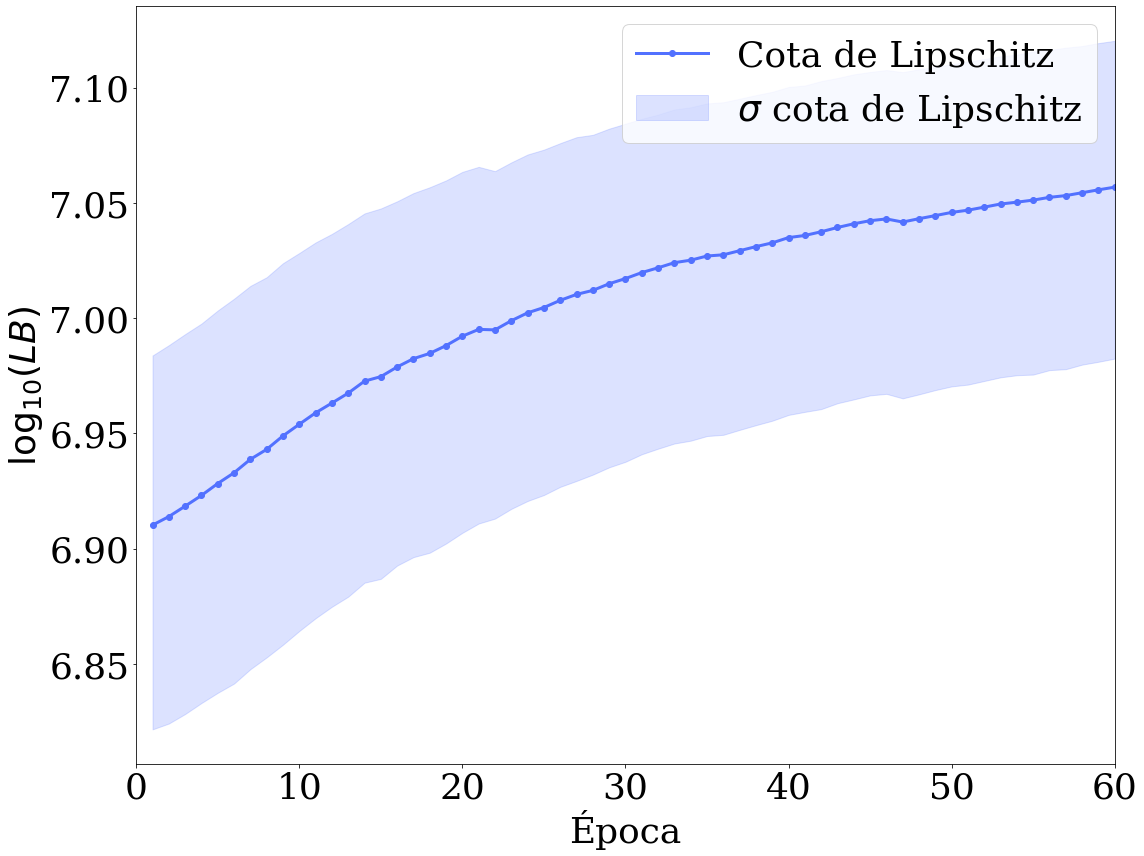

In [ ]:
skips = [15]
n_epochs = 60
resultGeneral = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.BinaryCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,l.l2(0))

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=y.reshape((100,1)), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        y_pred = np.around(y_)
        
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=y_pred))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train[test_index].reshape((360,1)), y_pred=y_).numpy()
      y_pred = np.around(y_)
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=y_pred)

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = np.around(model(X_test))
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=y_test_))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  resultGeneral[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoD2convencional.csv')

### Evaluación en test modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneral[skip][5])
  std_test = np.std(resultGeneral[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 15, test 98.83 +/- 1.304


### Evaluación en entrenamiento

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneral[skip][0][x][-1] for x in resultGeneral[skip][0]])
  std_train = np.std([resultGeneral[skip][0][x][-1] for x in resultGeneral[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 15, train 99.33 +/- 0.205


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización Alternante cota Lipschitz

In [ ]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, Model = None, name="adaptativeRegularLB"):
        super().__init__(name=name)
        self.Model = Model

    def call(self, y_true, y_pred):
        self.Model._callable_losses.clear()
        cce = tf.keras.losses.BinaryCrossentropy()
        loss = tf.cast(cce(y_true, y_pred), "float32")
        self.eig_values_radom(self.Model)
        loss += sum(self.Model.losses)
        return  loss 

    def eig_values_radom(self, Model):
      allLayers = self.Model.layers
      nLayers = len(allLayers)
      randomLayer = np.random.choice(np.append([1], [np.arange(2,nLayers,2)]), size=1)[0]
      EigVal = np.linalg.norm(allLayers[randomLayer].get_weights()[0], ord=2)
      self.Model.add_loss(lambda: EigVal*tf.norm(allLayers[randomLayer].trainable_variables[0], ord=2))
      return 

Modelo : 15 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
14
Tiempo total 45.46287250518799 en k-fold 1
14
Tiempo total 41.99564719200134 en k-fold 2
14
Tiempo total 40.81700277328491 en k-fold 3
14
Tiempo total 39.22608709335327 en k-fold 4
14
Tiempo total 34.81799030303955 en k-fold 5


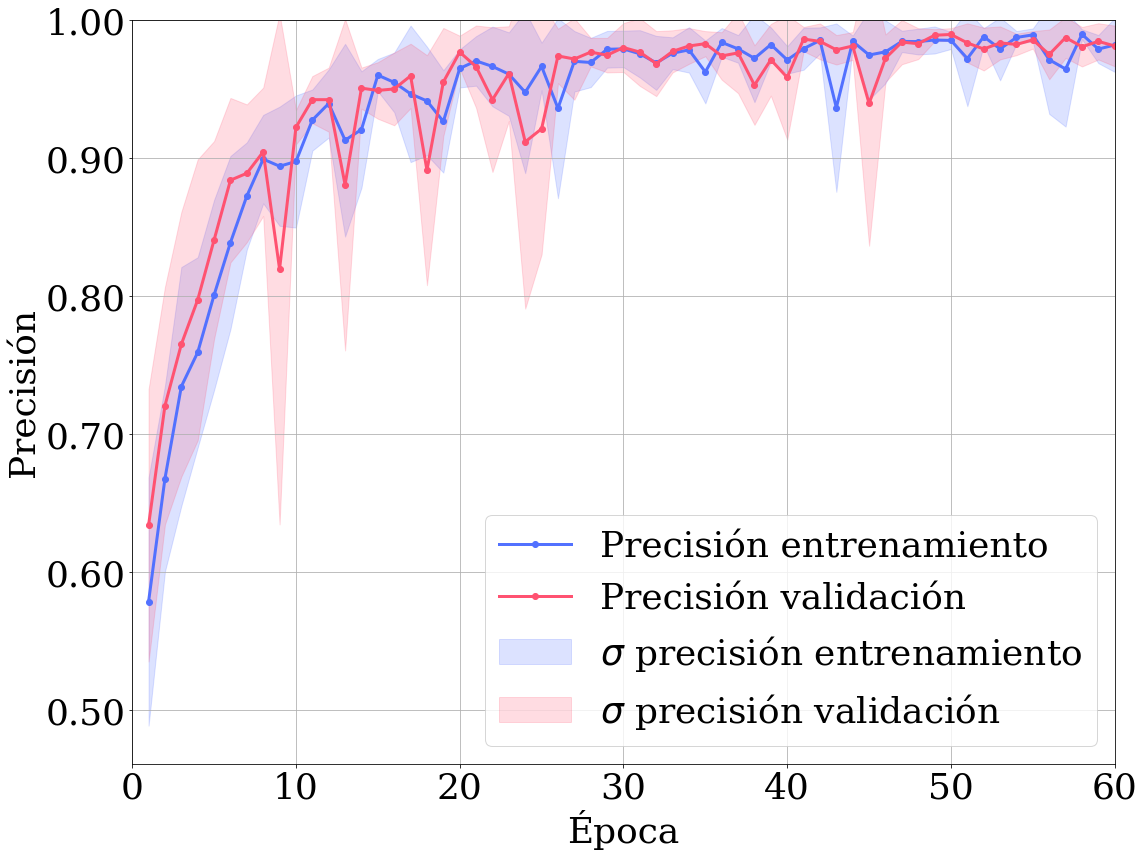

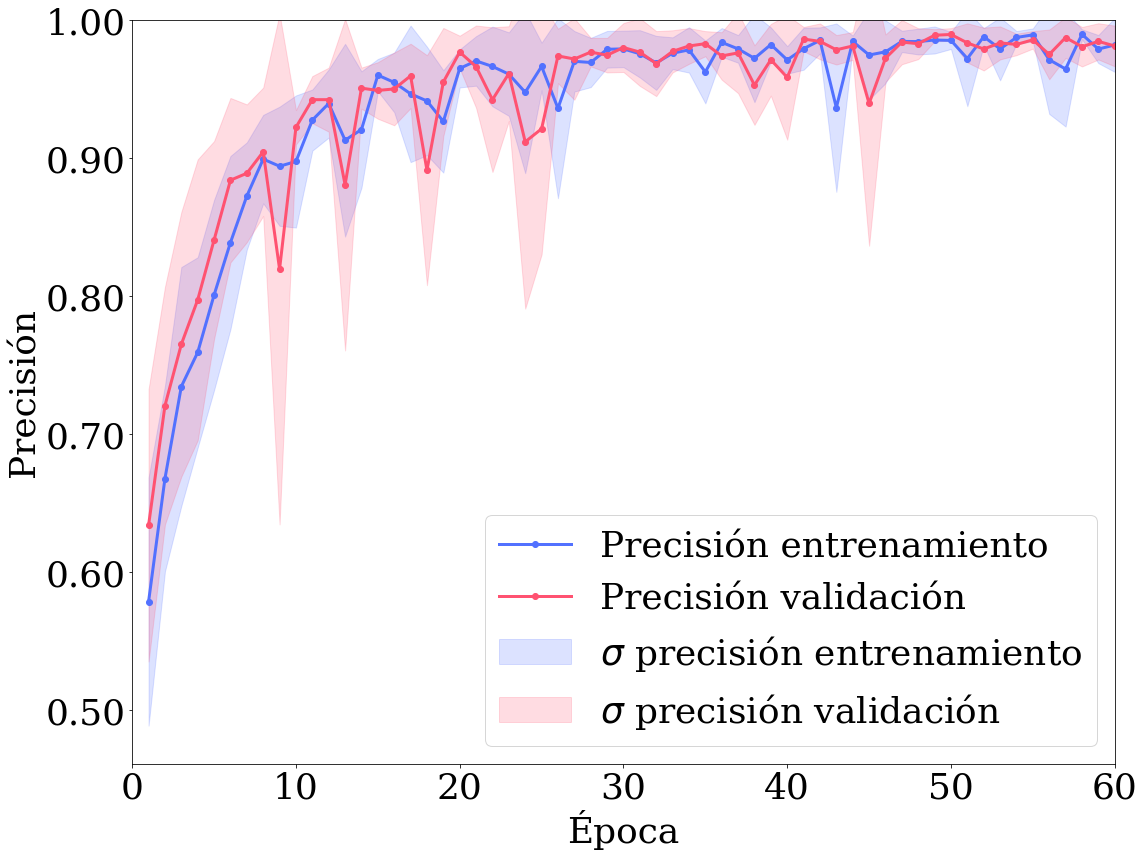

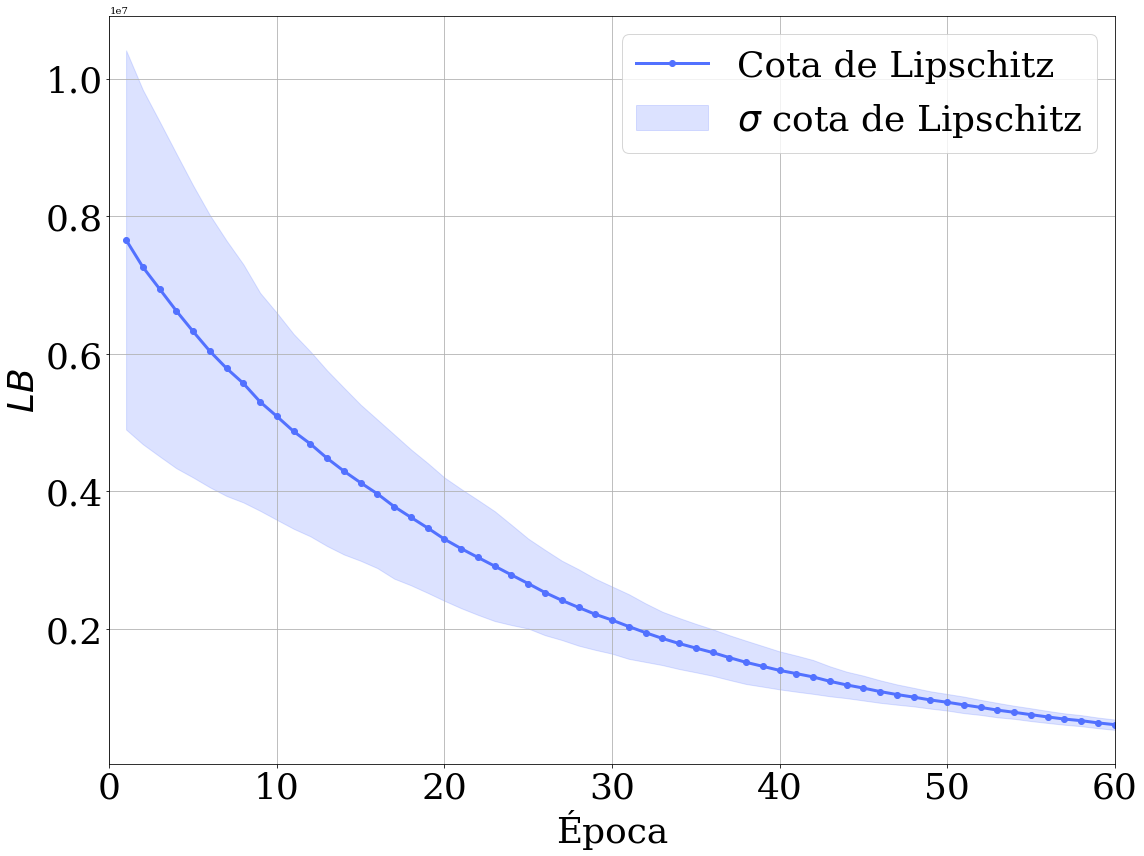

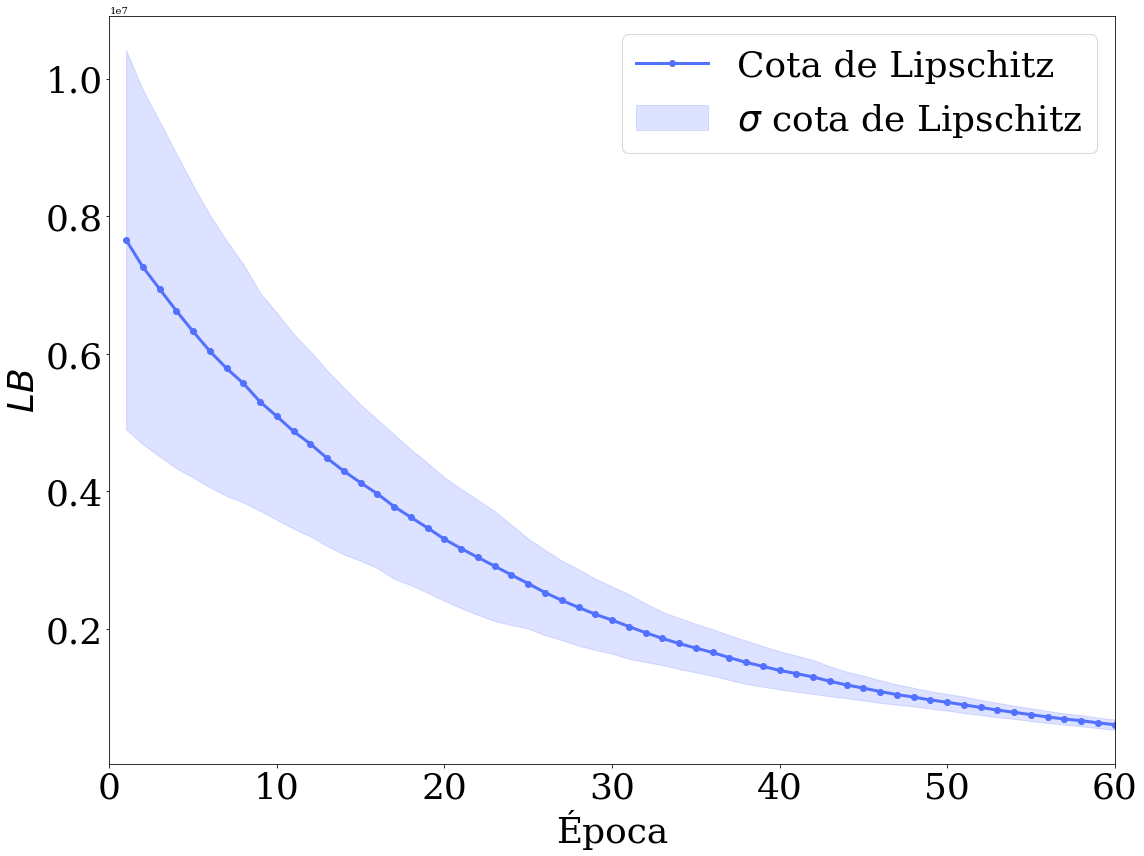

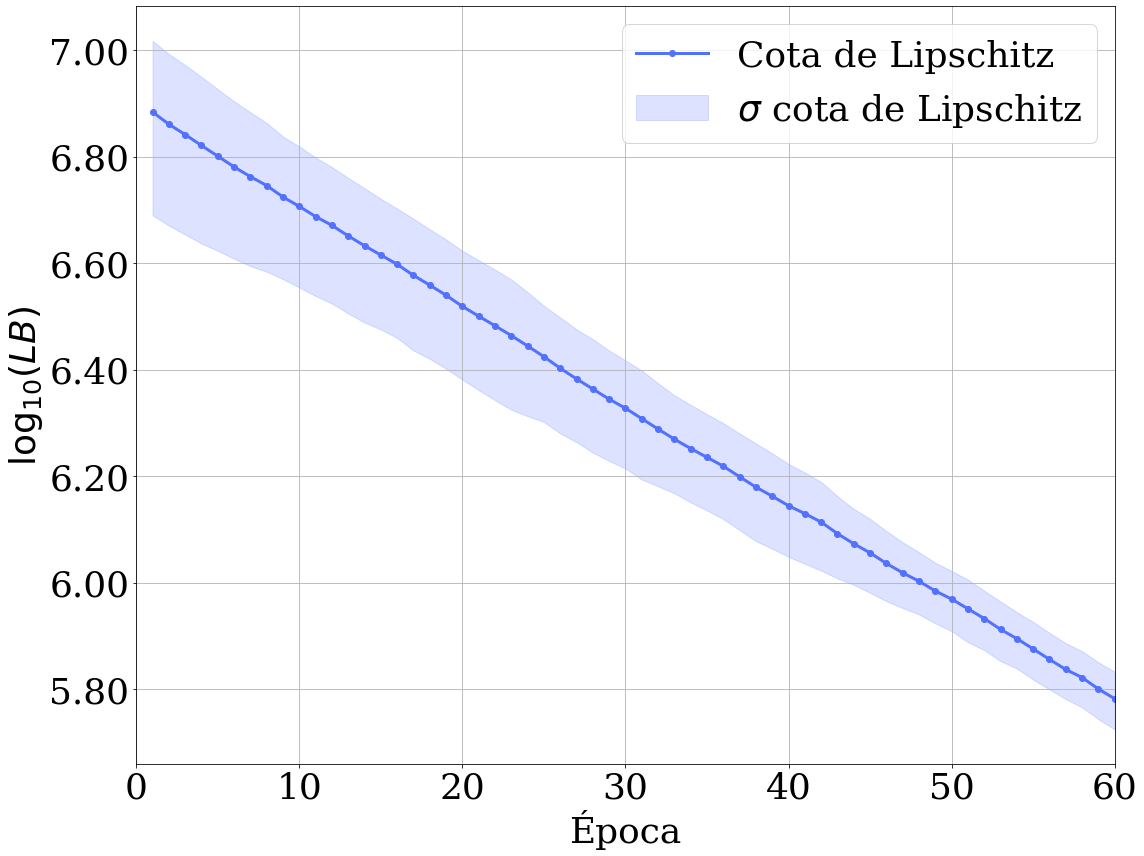

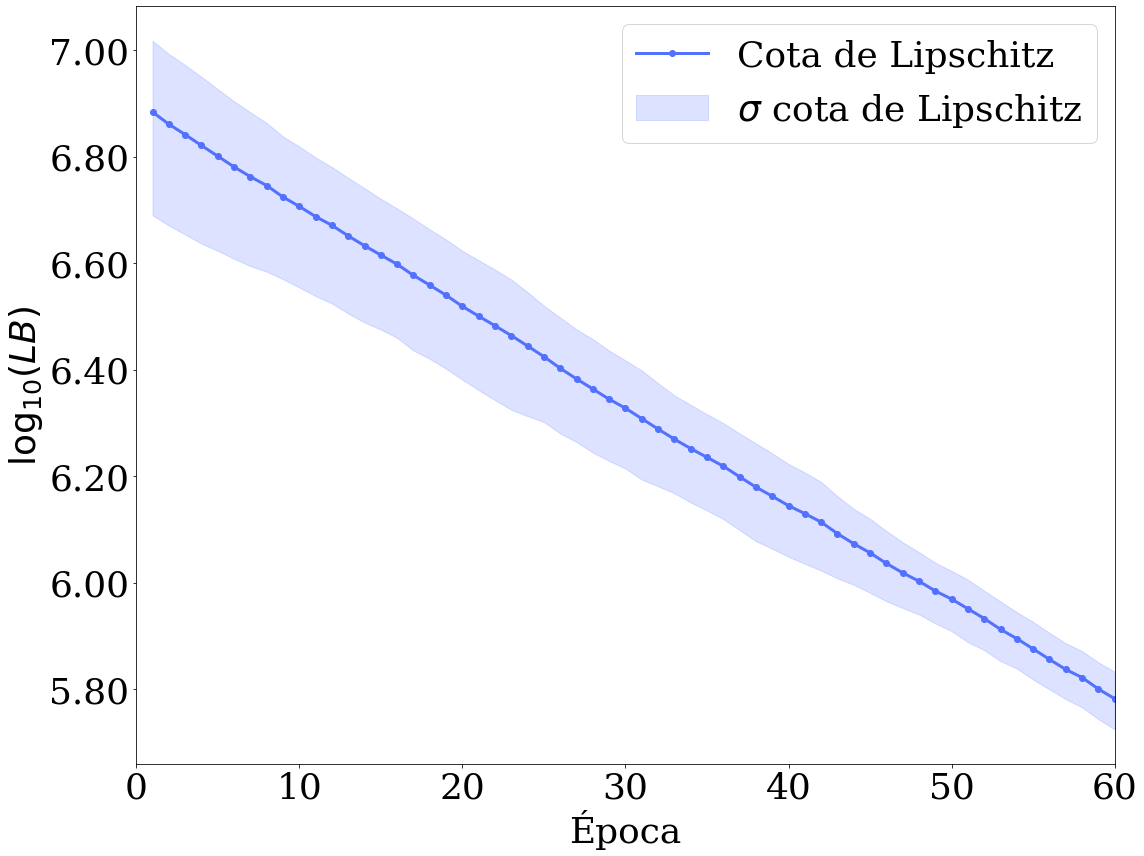

In [ ]:
skips = [15]
n_epochs = 60
resultGeneralLB = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.BinaryCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,l.l2(0))

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          lossC = CustomLoss(Model = model)
          loss = lossC(y_true = y.reshape((100,1)), y_pred=y_)
         
          #loss = ce_loss(y_true=y.reshape((10,1)), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        #y_pred = np.around(y_)
        
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, 
                                                     y_pred=np.around(y_)))
      #breakpoint()
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train[test_index].reshape((360,1)), y_pred=y_).numpy()
      #coy_pred = np.around(y_)
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=np.around(y_))

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = np.around(model(X_test))
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=y_test_))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  #graphGridLoss(skip)
  #graphLoss(skip)

  resultGeneralLB[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralLB), 'ResultadosExperimentoD1LB.csv')


### Evaluación en test de los modelos 

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralLB[skip][5])
  std_test = np.std(resultGeneralLB[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 15, test 98.80 +/- 0.620


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralLB[skip][0][x][-1] for x in resultGeneralLB[skip][0]])
  std_train = np.std([resultGeneralLB[skip][0][x][-1] for x in resultGeneralLB[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 15, train 98.19 +/- 1.747


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L2

### Sintonización hiper-parámetro

In [ ]:
skips = [15]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ l.l2(0.1), l.l2(0.01), l.l2(0.001), l.l2(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l2}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='binary_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train[train_index],
                epochs = 60, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 15, parametro 0.10000000149011612
Kfold 1 acc train 0.7472222447395325, acc test 0.7555555701255798
Kfold 2 acc train 0.9201388955116272, acc test 0.9388889074325562
Kfold 3 acc train 0.9444444179534912, acc test 0.9138888716697693
Kfold 4 acc train 0.9034722447395325, acc test 0.8972222208976746
Kfold 5 acc train 0.9277777671813965, acc test 0.9305555820465088
Fin modelo: promedio acc train 0.888611114025116,std 0.07191251784835613
Fin modelo: promedio acc test 0.8872222304344177,std 0.06737127559262948


Modelo 15, parametro 0.009999999776482582
Kfold 1 acc train 0.981249988079071, acc test 0.9888888597488403
Kfold 2 acc train 0.9923611283302307, acc test 0.9916666746139526
Kfold 3 acc train 0.9944444298744202, acc test 0.9888888597488403
Kfold 4 acc train 0.9902777671813965, acc test 0.980555534362793
Kfold 5 acc train 0.9965277910232544, acc test 0.9861111044883728
Fin modelo: promedio acc train 0.9909722208976746,std 0.005288737758630528
Fin modelo: promedio acc test 0.9872

In [ ]:
regularParameters = {15: l.l2(0.0001)}
regularParameters

{15: <keras.regularizers.L2 at 0x7fcc7b94d460>}

### Entrenamiento

Modelo : 15 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
14
Tiempo total 39.56738901138306 en k-fold 1
14
Tiempo total 36.188122034072876 en k-fold 2
14
Tiempo total 36.47648477554321 en k-fold 3
14
Tiempo total 30.850510597229004 en k-fold 4
14
Tiempo total 31.145045280456543 en k-fold 5


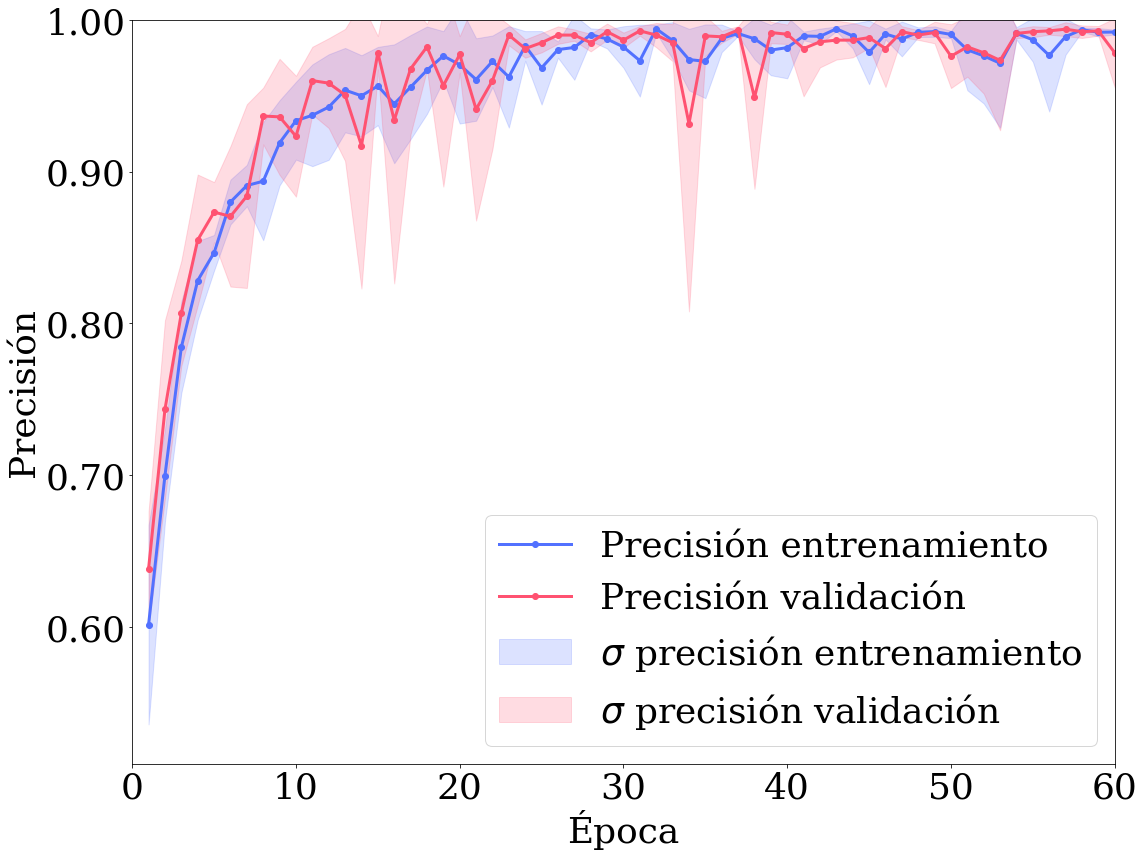

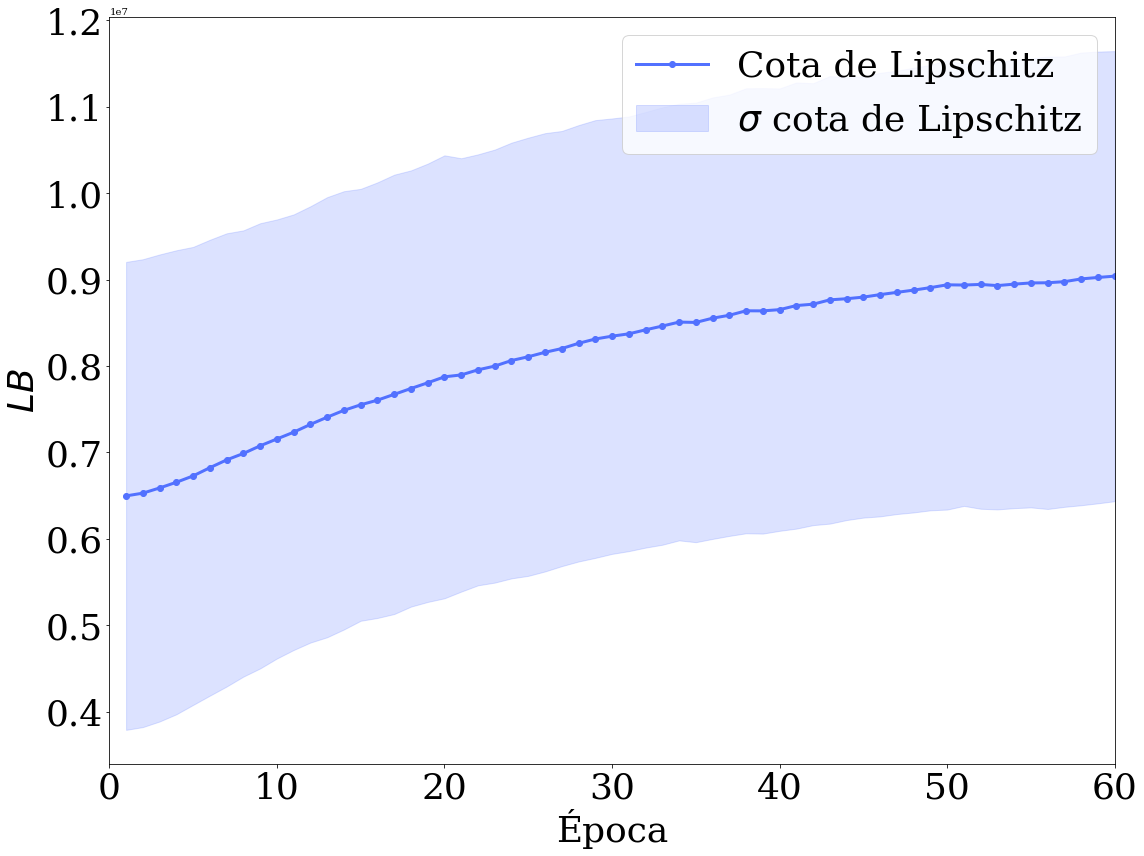

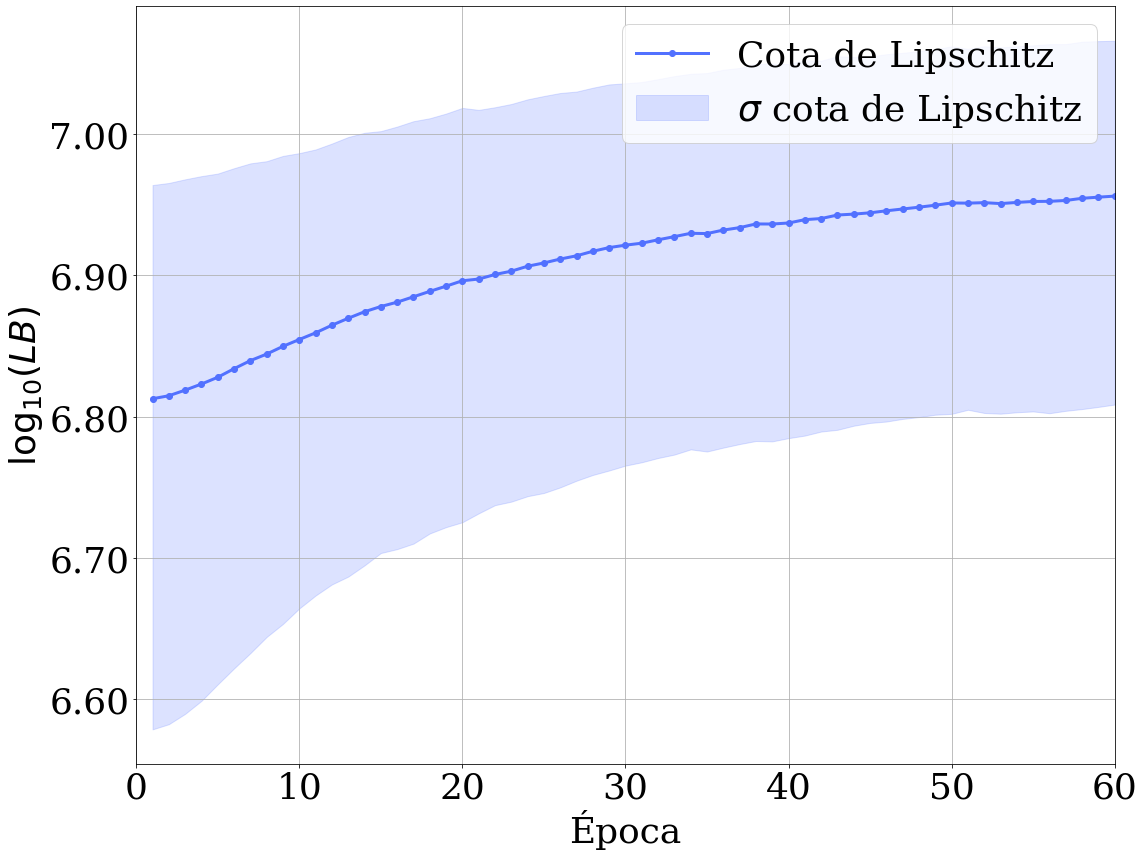

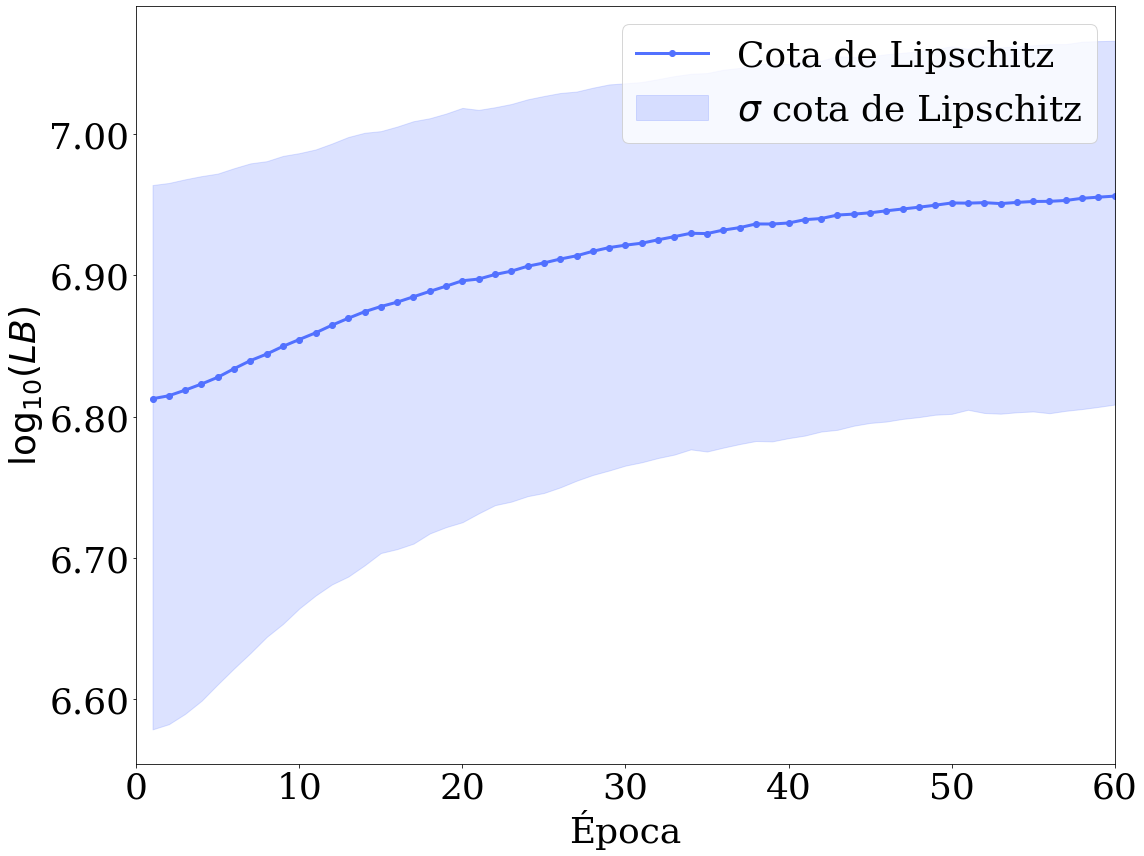

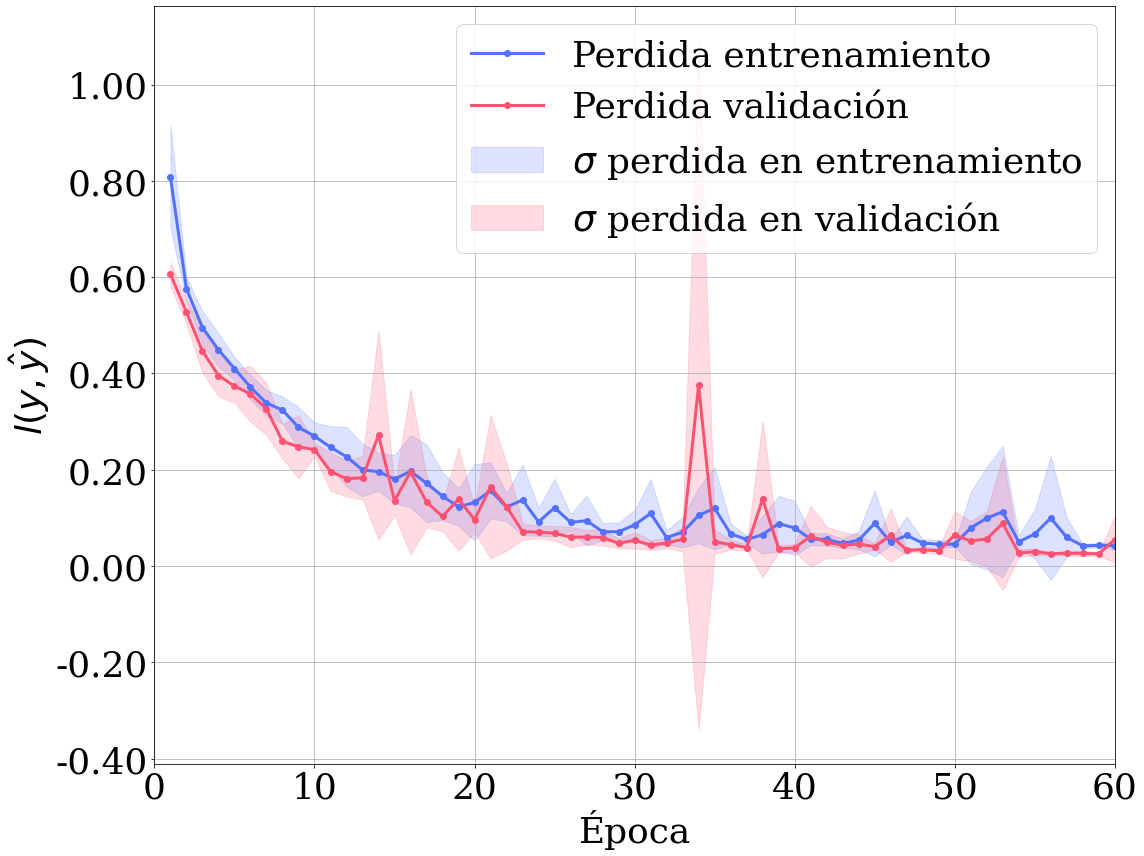

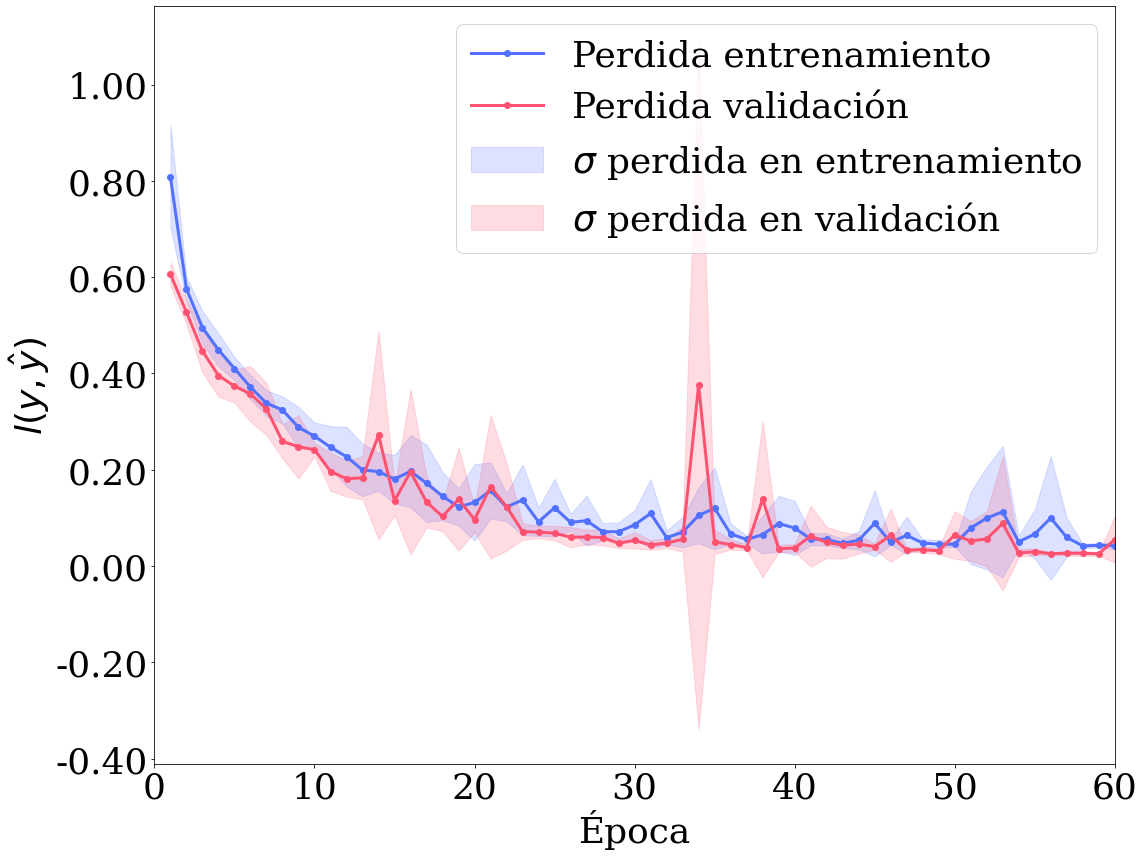

In [ ]:
skips = [15]
n_epochs = 60
resultGeneralL2 = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.BinaryCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,regularParameters[skip])

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=y.reshape((100,1)), y_pred=y_)
          loss += tf.add_n(model.losses)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        y_pred = np.around(y_)
        
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=y_pred))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train[test_index].reshape((360,1)), y_pred=y_).numpy()
      y_pred = np.around(y_)
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=y_pred)

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = np.around(model(X_test))
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=y_test_))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  graphGridLoss(skip)
  graphLoss(skip)

  resultGeneralL2[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralL2), 'ResultadosExperimentoC3L2.csv')

### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralL2[skip][5])
  std_test = np.std(resultGeneralL2[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 15, test 99.80 +/- 0.155


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralL2[skip][0][x][-1] for x in resultGeneralL2[skip][0]])
  std_train = np.std([resultGeneralL2[skip][0][x][-1] for x in resultGeneralL2[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 15, train 99.83 +/- 0.242


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método Regularización L1

### Sintonización hiper-parámetro

In [ ]:
skips = [15]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ l.l1(0.1), l.l1(0.01), l.l1(0.001), l.l1(0.0001)]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param.l1}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_model(skip,param)
      model.compile(loss='binary_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train[train_index],
                epochs = 60, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 15, parametro 0.10000000149011612
Kfold 1 acc train 0.5083333253860474, acc test 0.46666666865348816
Kfold 2 acc train 0.5055555701255798, acc test 0.47777777910232544
Kfold 3 acc train 0.5076388716697693, acc test 0.4694444537162781
Kfold 4 acc train 0.5020833611488342, acc test 0.49166667461395264
Kfold 5 acc train 0.5027777552604675, acc test 0.4888888895511627
Fin modelo: promedio acc train 0.5052777767181397,std 0.0025076967252051314
Fin modelo: promedio acc test 0.47888889312744143,std 0.010030816611334438


Modelo 15, parametro 0.009999999776482582
Kfold 1 acc train 0.9847221970558167, acc test 0.9861111044883728
Kfold 2 acc train 0.9916666746139526, acc test 0.9916666746139526
Kfold 3 acc train 0.9375, acc test 0.9444444179534912
Kfold 4 acc train 0.988194465637207, acc test 0.9888888597488403
Kfold 5 acc train 0.9930555820465088, acc test 0.9972222447395325
Fin modelo: promedio acc train 0.979027783870697,std 0.020964407505216623
Fin modelo: promedio acc test 0.98166666

In [ ]:
regularParameters = {15: l.l1(0.001)}
regularParameters

{15: <keras.regularizers.L1 at 0x7fcc7b9e74c0>}

### Entrenamiento

Modelo : 15 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
14
Tiempo total 37.55928874015808 en k-fold 1
14
Tiempo total 32.31265068054199 en k-fold 2
14
Tiempo total 33.29811763763428 en k-fold 3
14
Tiempo total 33.99137997627258 en k-fold 4
14
Tiempo total 39.87106943130493 en k-fold 5


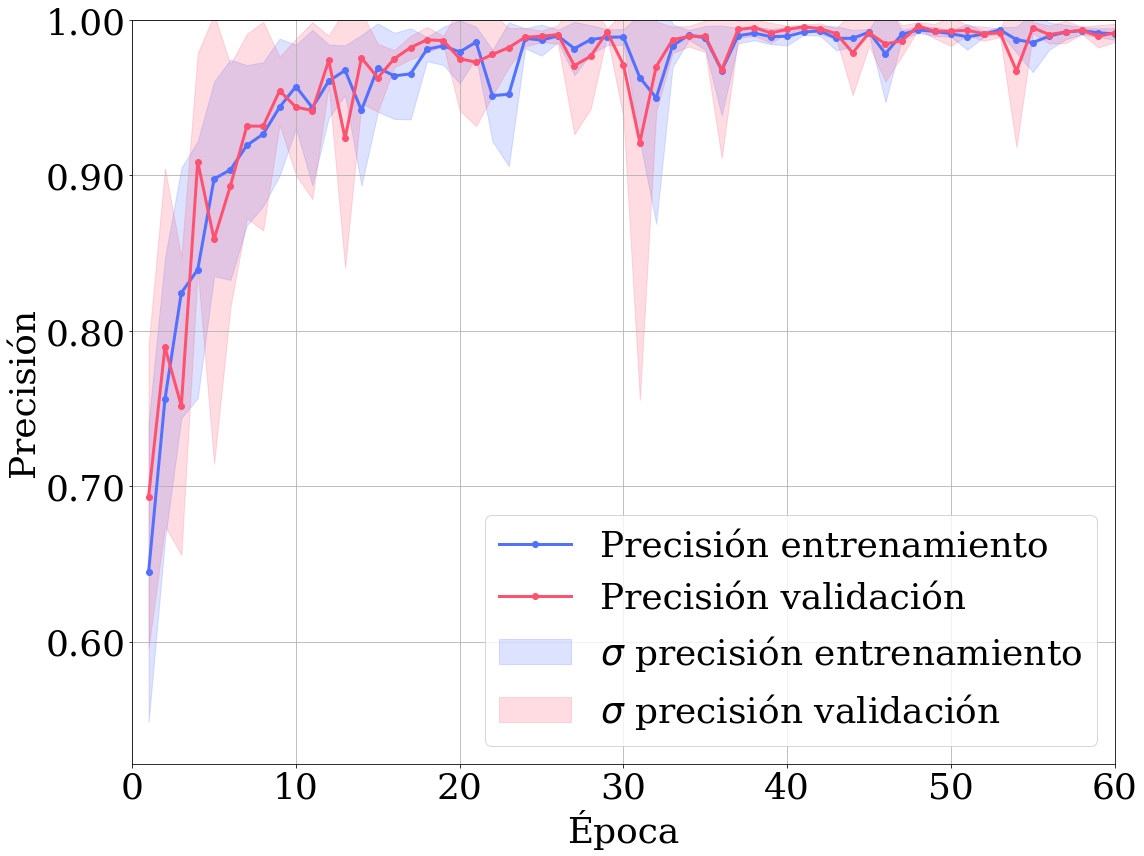

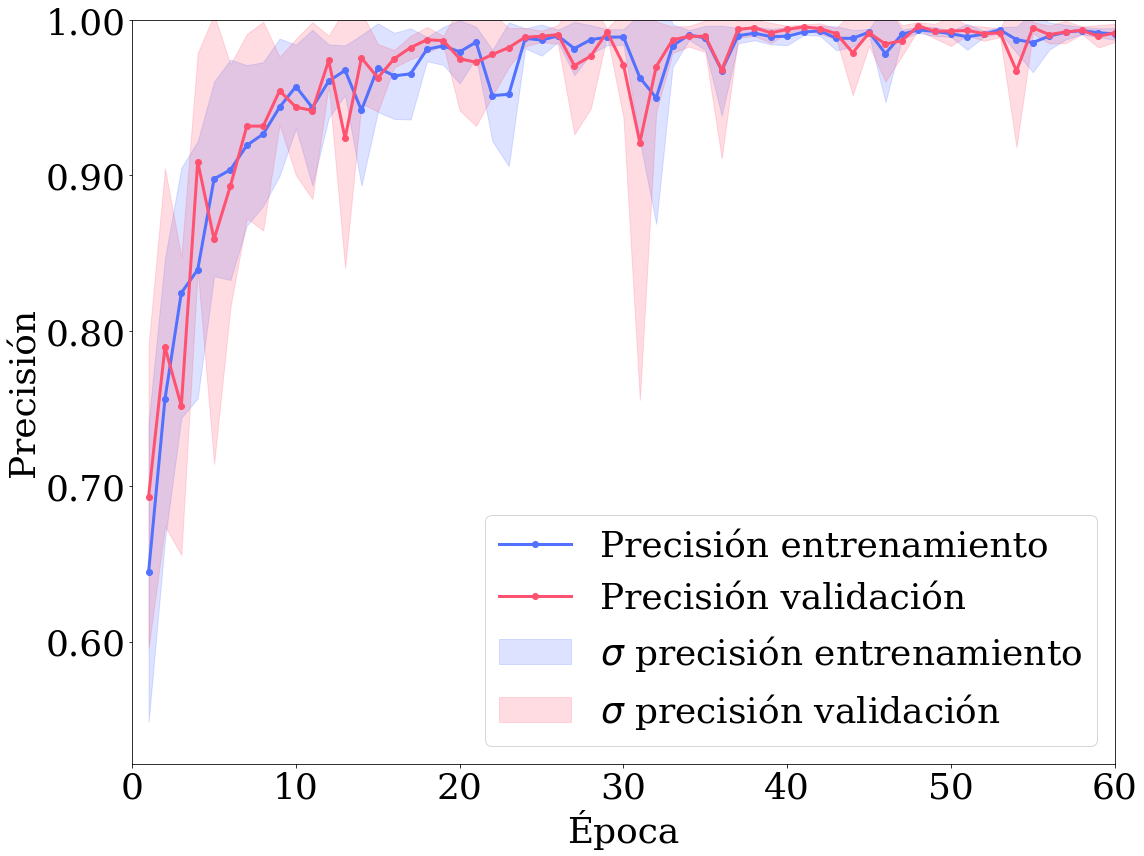

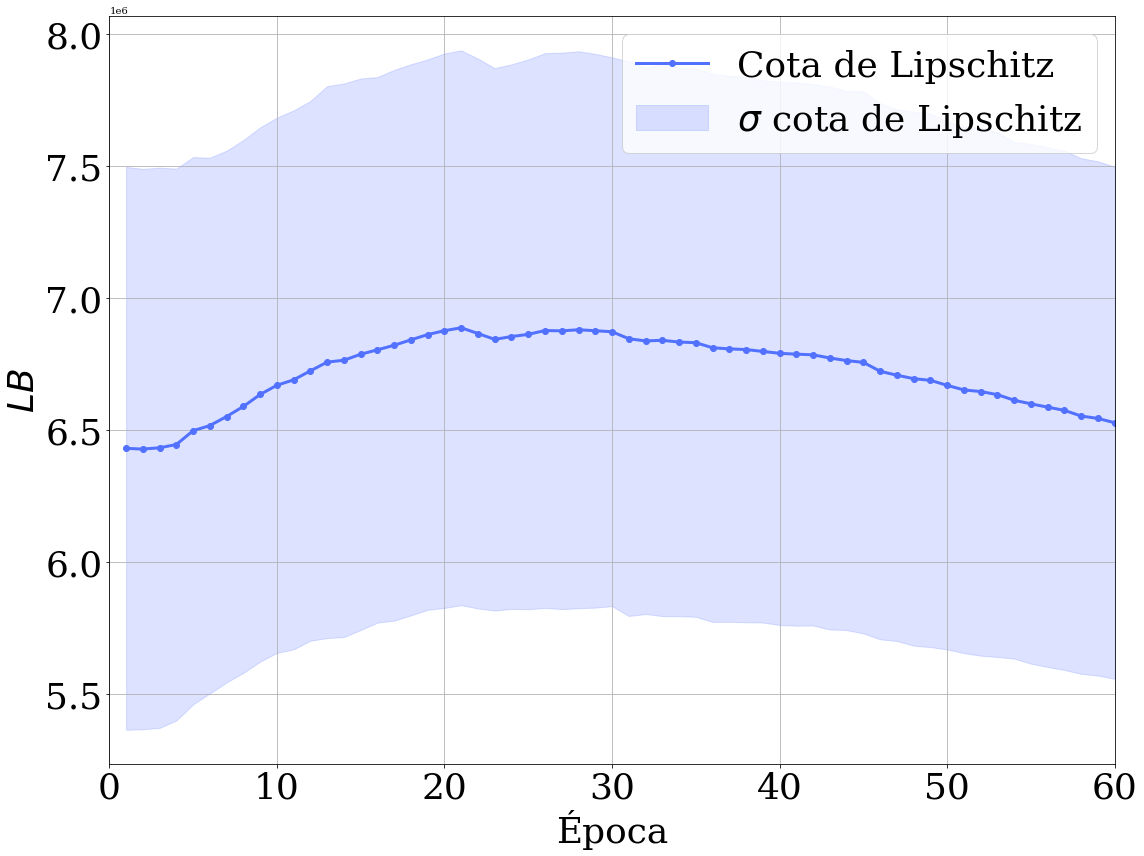

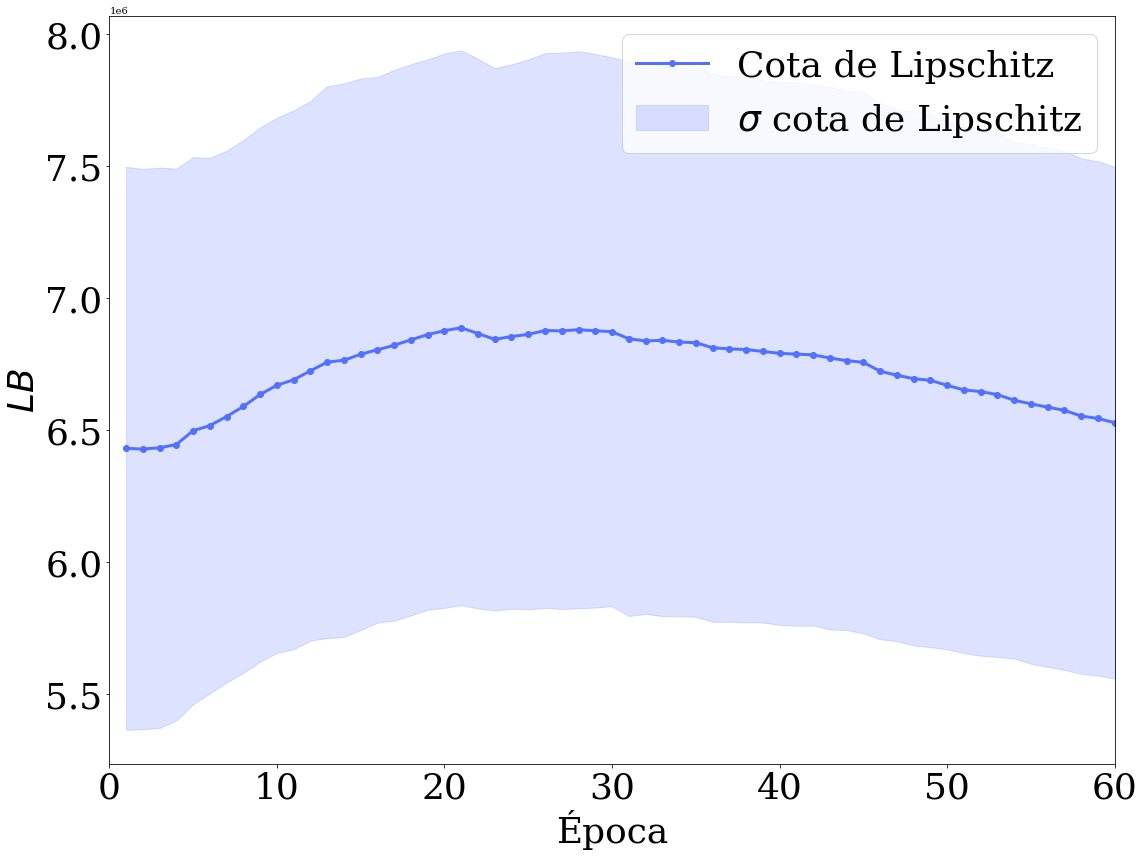

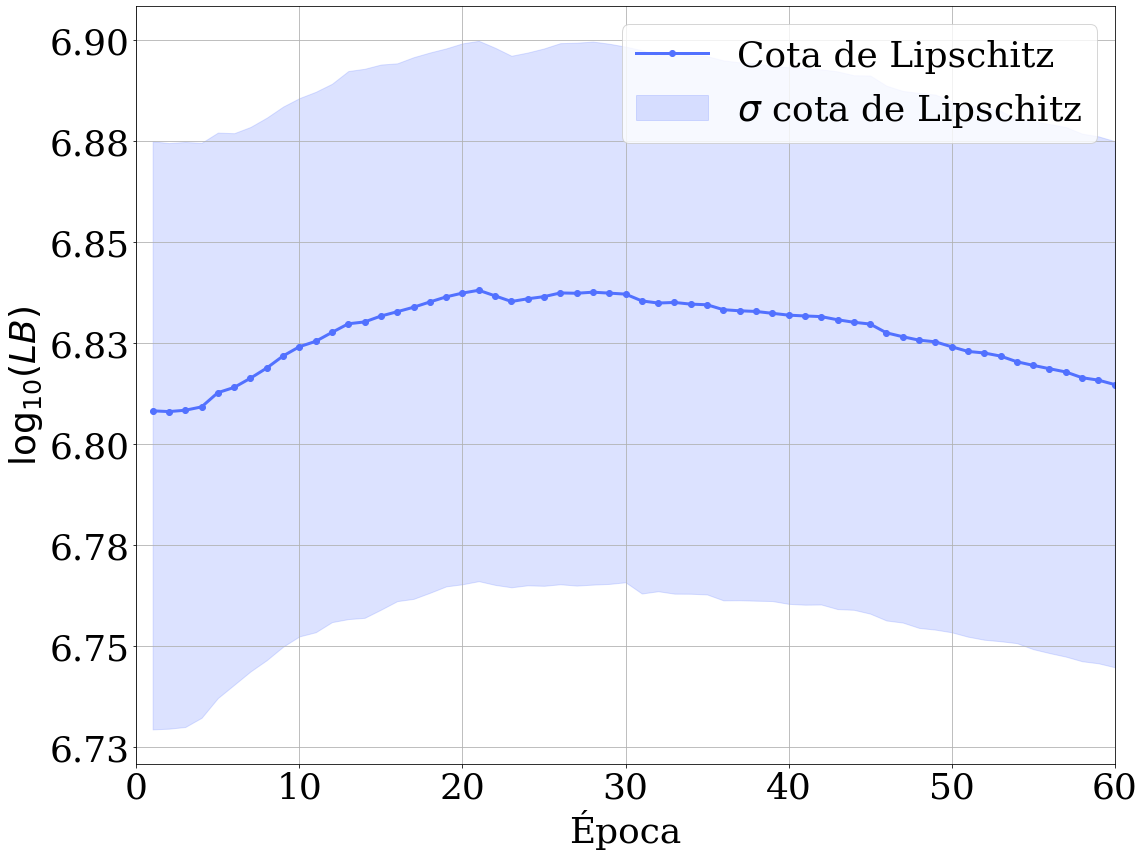

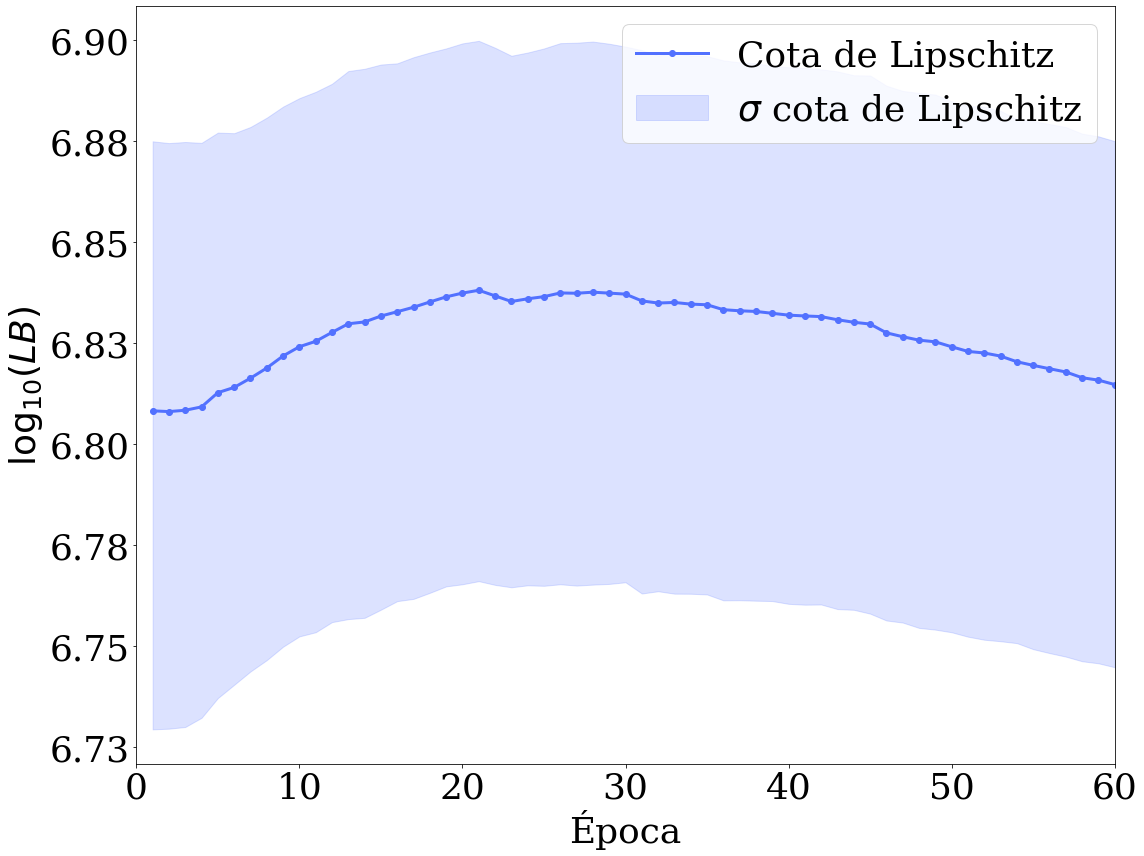

In [ ]:
skips = [15]
n_epochs = 60
resultGeneralL1 = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.BinaryCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_model(skip,regularParameters[skip])

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=y.reshape((100,1)), y_pred=y_)
          loss += tf.add_n(model.losses)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        y_pred = np.around(y_)
        
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=y_pred))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train[test_index].reshape((360,1)), y_pred=y_).numpy()
      y_pred = np.around(y_)
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=y_pred)

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = np.around(model(X_test))
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=y_test_))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  graphGridLoss(skip)
  graphLoss(skip)

  resultGeneralL1[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneral), 'ResultadosExperimentoC3L1.csv')

### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralL1[skip][5])
  std_test = np.std(resultGeneralL1[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 15, test 99.53 +/- 0.239


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralL1[skip][0][x][-1] for x in resultGeneralL1[skip][0]])
  std_train = np.std([resultGeneralL1[skip][0][x][-1] for x in resultGeneralL1[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 15, train 99.10 +/- 0.334


## Entrenamiento conjunto de modelos validación cruzada k-fold - Método *Dropout*

### Modelo DropOut

In [ ]:
from keras.layers.regularization.dropout import Dropout

def skip_conectionDropOut(dense_input, n, regular_l, probabilityDrop):
  if n >= 2:
    resDense = Dense(10, activation ='tanh', kernel_regularizer=regular_l)(dense_input)
    resDenseDropOut = Dropout((probabilityDrop))(resDense)
    return skip_conection(Add()([dense_input, resDenseDropOut]), n-1, regular_l)
  resDenseo = Dense(10, activation ='tanh', kernel_regularizer=regular_l)(dense_input)
  resDenseoDropOut = Dropout((probabilityDrop))(resDenseo)
  return Add()([dense_input, resDenseo])

In [ ]:
def load_modelDropOut(n, regular_l, probabilityDrop):
  keras.backend.clear_session()
  inputs  = Input(shape=(2,))
  dense1  = Dense(10,  activation  ='tanh', kernel_regularizer=regular_l)(inputs)
  dense1DropOut = Dropout((probabilityDrop))(dense1)
  skip_final = skip_conectionDropOut(dense1DropOut, n, regular_l, probabilityDrop)

  outputs = Dense(1, activation='sigmoid', kernel_regularizer=regular_l)(skip_final)
  return keras.Model(inputs=inputs, outputs=outputs, name='RestNetCustomModelExperimentoA')

### Sintonización hiper-parámetro

In [ ]:
skips = [15]
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
for skip in skips:
  for param in param_grid:
    print(f'Modelo {skip}, parametro {param}')
    i = 0
    acc_train = []
    acc_test = []
    for train_index, test_index in kf.split(X_train): 
      model = load_modelDropOut(skip, l.l2(0), param)
      model.compile(loss='binary_crossentropy',
                  optimizer='SGD', 
                  metrics=['accuracy'])
      model.fit(X_train[train_index], 
                y_train[train_index],
                epochs = 30, verbose = 0)
      acc_train.append(model.evaluate(X_train[train_index], y_train[train_index],verbose = 0)[1])
      acc_test.append(model.evaluate(X_train[test_index], y_train[test_index], verbose = 0)[1])
      print(f'Kfold {i+1} acc train {acc_train[i]}, acc test {acc_test[i]}')
      i+=1
    print(f'Fin modelo: promedio acc train {np.mean(acc_train)},std {np.std(acc_train)}')
    print(f'Fin modelo: promedio acc test {np.mean(acc_test)},std {np.std(acc_test)}')
    print('\n')

Modelo 15, parametro 0.2
Kfold 1 acc train 0.6805555820465088, acc test 0.6722221970558167
Kfold 2 acc train 0.7729166746139526, acc test 0.7611111402511597
Kfold 3 acc train 0.8166666626930237, acc test 0.8472222089767456
Kfold 4 acc train 0.6486111283302307, acc test 0.6027777791023254
Kfold 5 acc train 0.9006944298744202, acc test 0.8999999761581421
Fin modelo: promedio acc train 0.7638888955116272,std 0.09145069980690945
Fin modelo: promedio acc test 0.7566666603088379,std 0.10915782643671763


Modelo 15, parametro 0.4
Kfold 1 acc train 0.47430557012557983, acc test 0.4972222149372101
Kfold 2 acc train 0.6666666865348816, acc test 0.6833333373069763
Kfold 3 acc train 0.4243055582046509, acc test 0.4472222328186035
Kfold 4 acc train 0.8062499761581421, acc test 0.7722222208976746
Kfold 5 acc train 0.793055534362793, acc test 0.7833333611488342
Fin modelo: promedio acc train 0.6329166650772095,std 0.15843233980919855
Fin modelo: promedio acc test 0.6366666734218598,std 0.139569448186

In [ ]:
regularParameters = {15: 0.4}
regularParameters

{15: 0.4}

### Entrenamiento

Modelo : 15 saltos residuales
Número de K-folds: KFold(n_splits=5, random_state=None, shuffle=False)

Iniciando Entrenamiento Validación Cruzada

 ----
14
Tiempo total 34.57958245277405 en k-fold 1
14
Tiempo total 30.495619535446167 en k-fold 2
14
Tiempo total 30.493427276611328 en k-fold 3
14
Tiempo total 32.79578709602356 en k-fold 4
14
Tiempo total 29.397172927856445 en k-fold 5


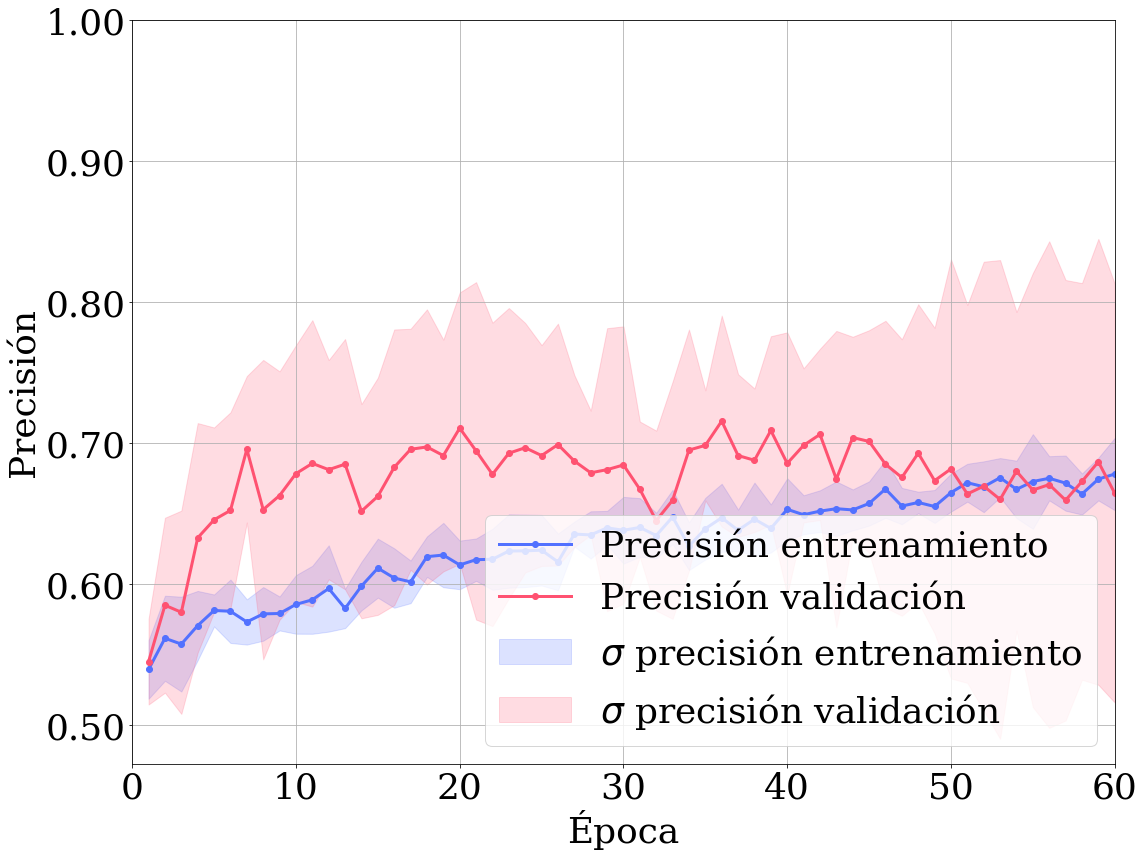

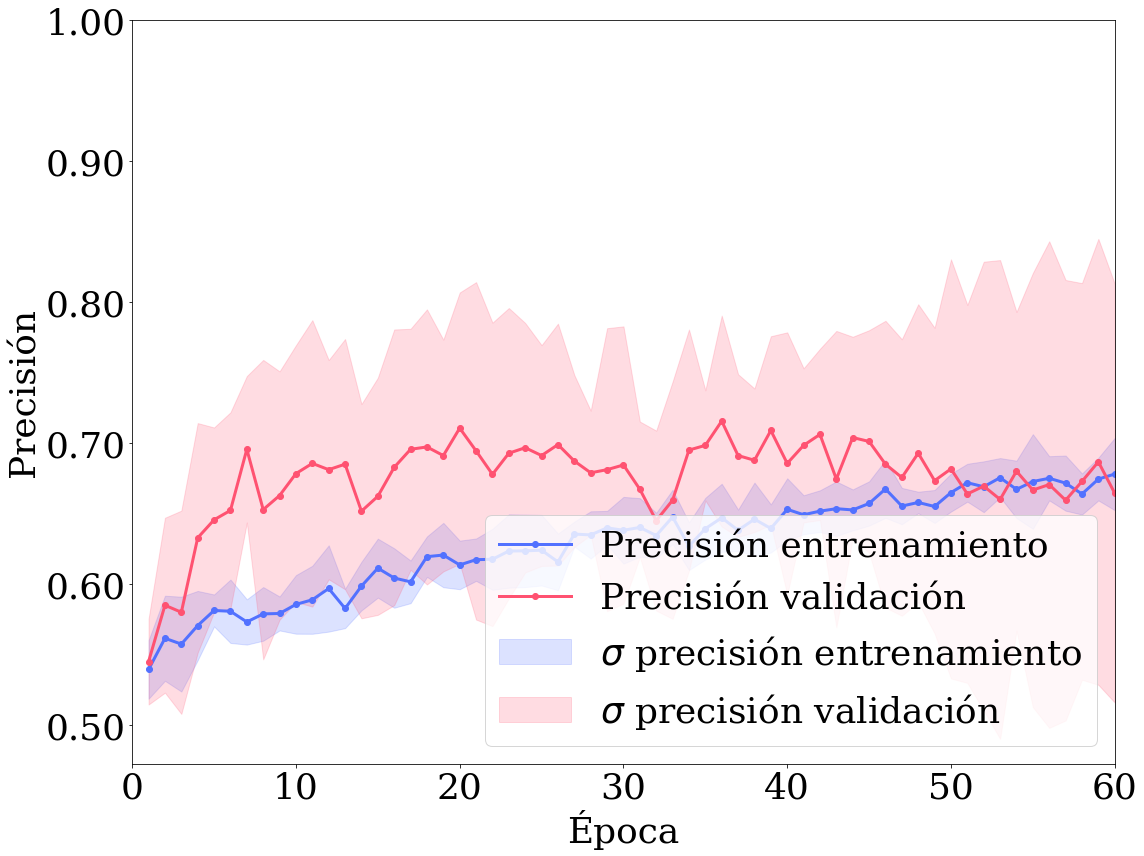

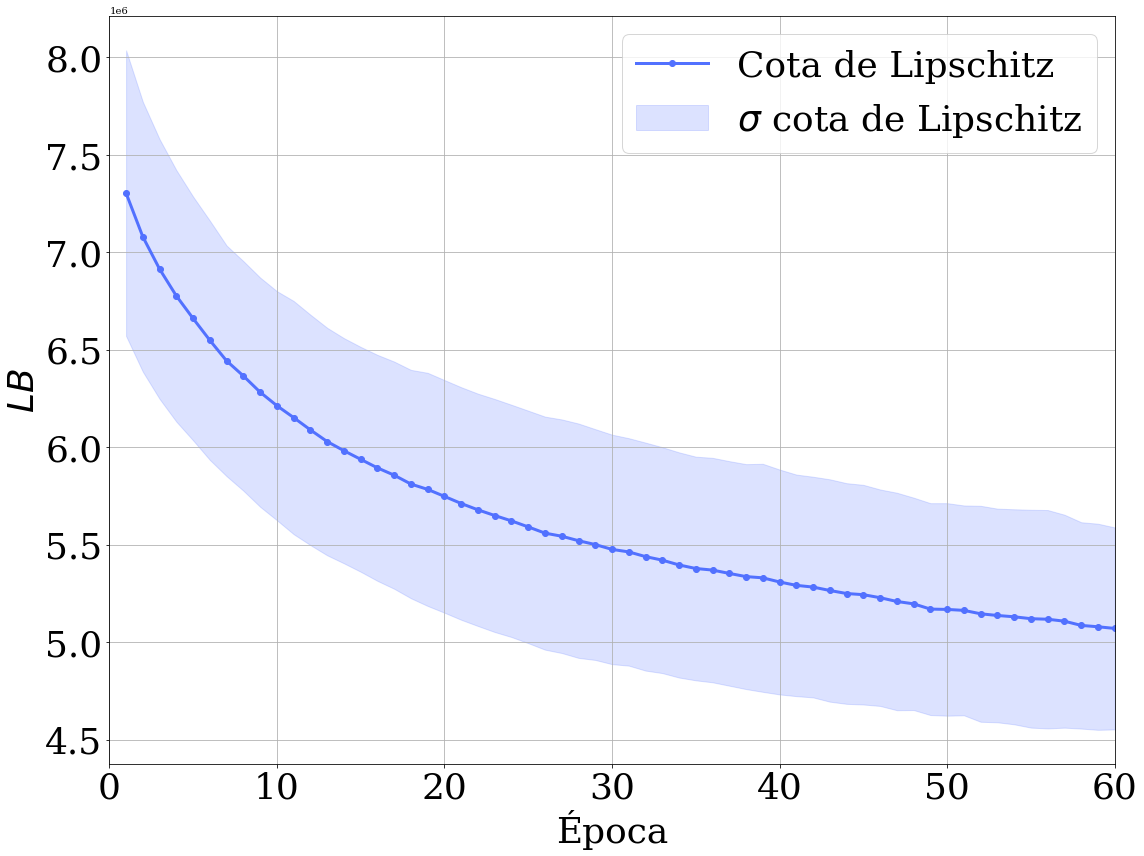

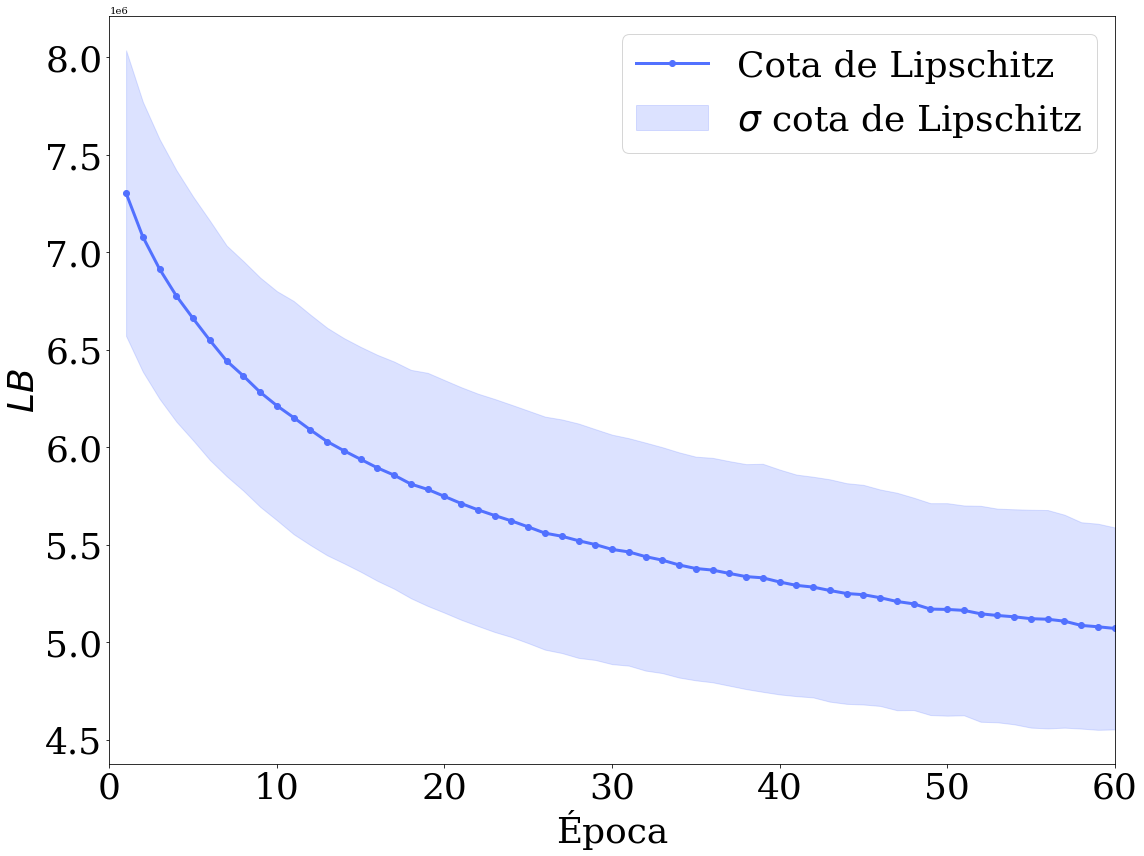

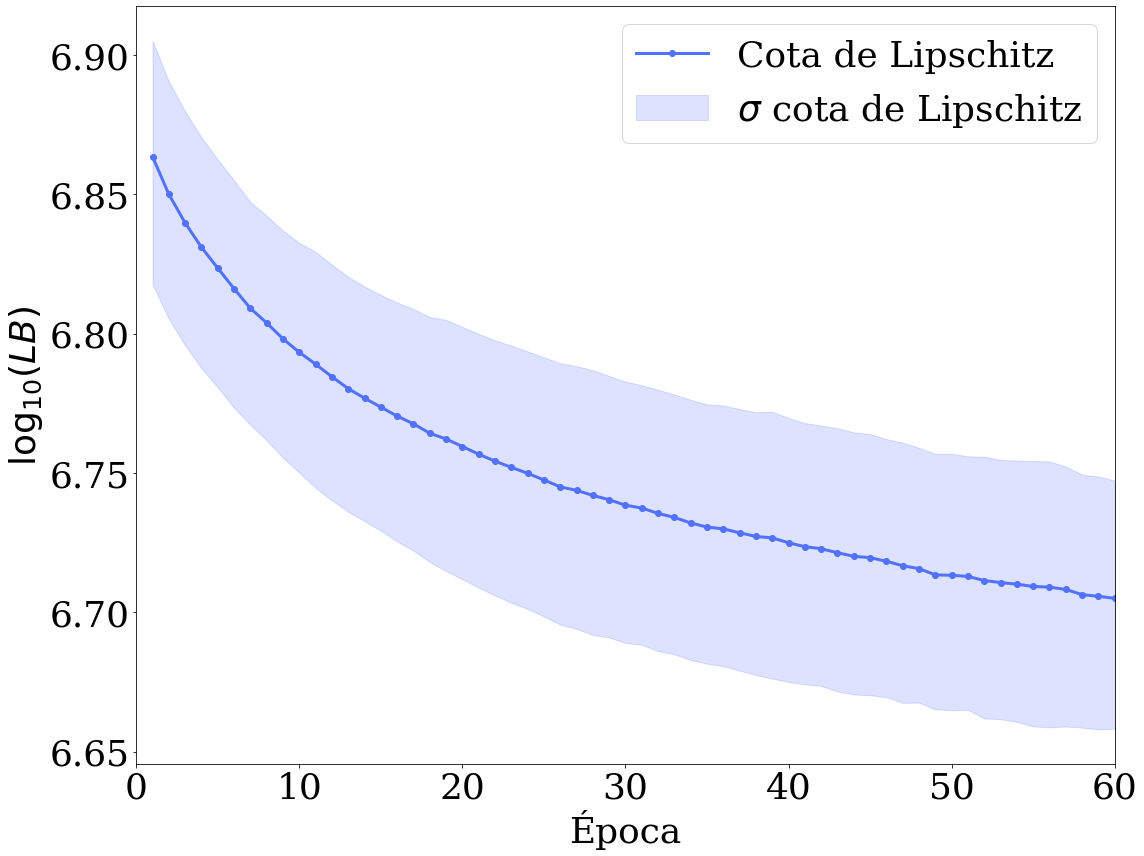

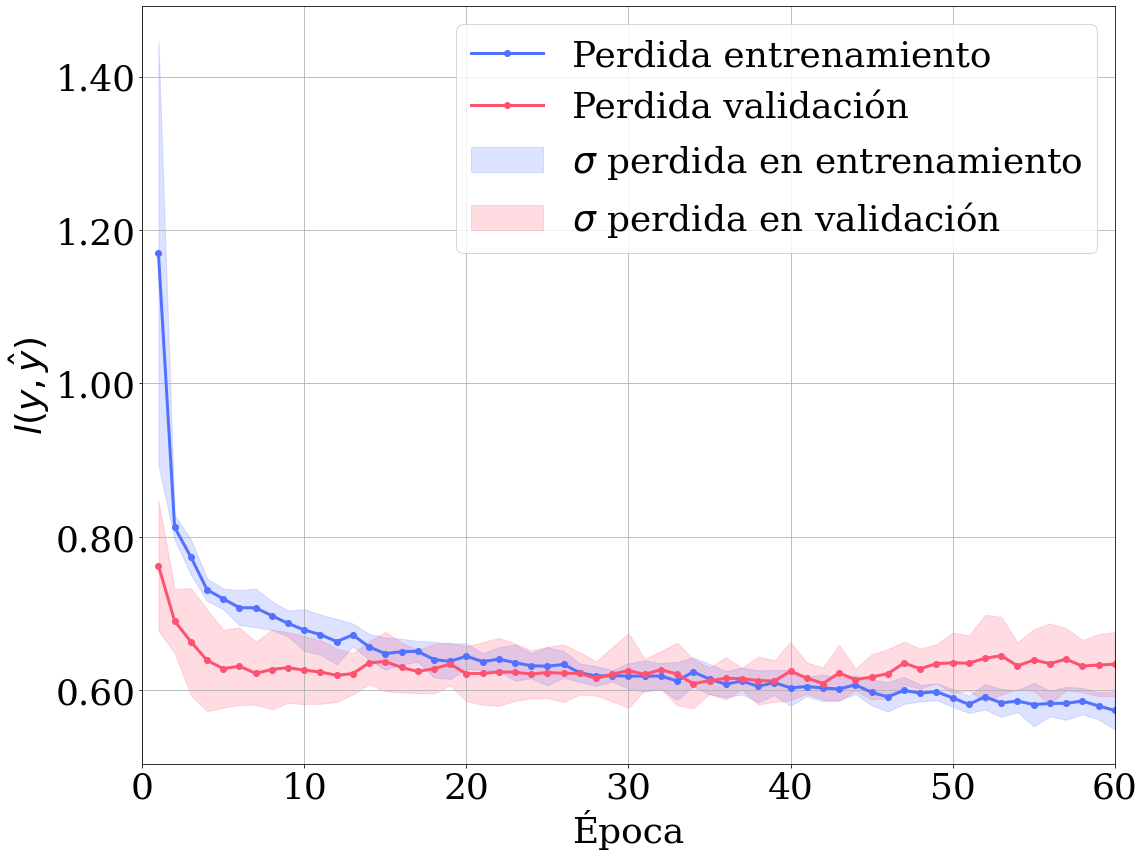

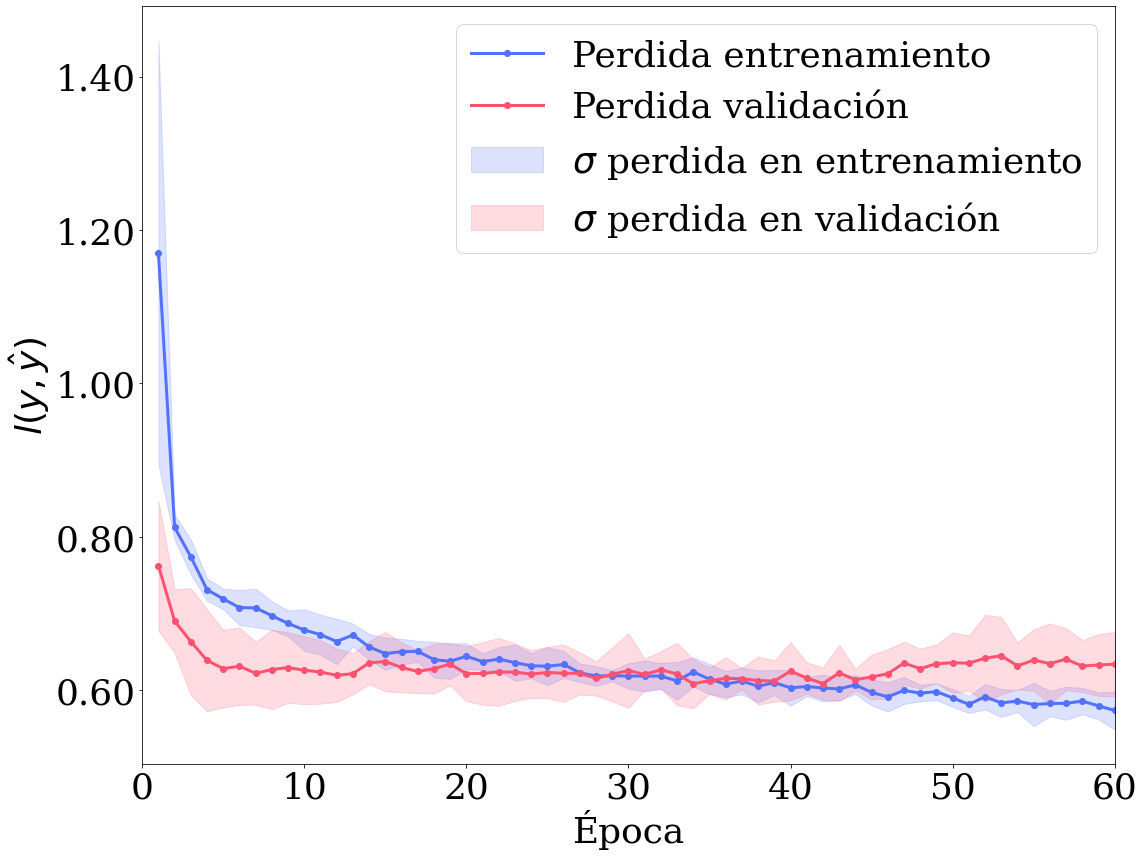

In [ ]:
skips = [15]
n_epochs = 60
resultGeneralDO = {}
for skip in skips:
  
  optimizer = tf.keras.optimizers.SGD()
  ce_loss = tf.keras.losses.BinaryCrossentropy()
  k_index = 0
  Kf_eval_train_M0 = {}
  Kf_eval_val_M0 = {}
  Kf_LB_M0 = {}
  Kf_loss = {}
  Kf_loss_val = {}
  acc_test = []

  print(f'Modelo : {skip} saltos residuales')

  kf = KFold(n_splits=5, shuffle=False)

  print(f'Número de K-folds: {kf}')
  print(f'\nIniciando Entrenamiento Validación Cruzada')
  print(f'\n ----')
  timeTotal = []
  
  for train_index, test_index in kf.split(X_train):
    timeStart = time.time()
    generator = DataGenerator(images=X_train[train_index], 
                              labels=y_train[train_index], 
                              batch_size=100, shuffle=True)
    n_batches = len(generator)
    print(n_batches)
    model = load_modelDropOut(skip,l.l2(0),regularParameters[skip])

    loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
    loss_val = np.zeros(shape=(n_epochs,))
    acc_val = np.zeros(shape=(n_epochs,))
    LB_1 = np.zeros(shape=(n_epochs,))
    
    for epoch in range(n_epochs):
      epoch_loss_avg = tf.keras.metrics.Mean() # Keeping track of the training loss
      epoch_acc_avg = tf.keras.metrics.Mean() # Keeping track of the training accuracy
      for batch in range(n_batches):
        x, y = generator[batch]

        with tf.GradientTape() as tape: # Forward pass
          y_ = model(x, training=True)
          loss = ce_loss(y_true=y.reshape((100,1)), y_pred=y_)
        
        grad = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables)) # Update network weights

        epoch_loss_avg(loss)
        y_pred = np.around(y_)
        
        epoch_acc_avg(sklearn.metrics.accuracy_score(y_true=y, y_pred=y_pred))
      
      generator.on_epoch_end()

      loss_train[epoch] = epoch_loss_avg.result()
      acc_train[epoch] = epoch_acc_avg.result()

      y_ = model(X_train[test_index]) # Validation predictions
      loss_val[epoch] = ce_loss(y_true=y_train[test_index].reshape((360,1)), y_pred=y_).numpy()
      y_pred = np.around(y_)
      acc_val[epoch] = sklearn.metrics.accuracy_score(y_true=y_train[test_index], 
                                                      y_pred=y_pred)

    
      LB = lipschitz_bound(model.get_weights())
      
      LB_1[epoch]= LB



    y_test_ = np.around(model(X_test))
    acc_test.append(sklearn.metrics.accuracy_score(y_true=y_test, 
                                                      y_pred=y_test_))

    Kf_eval_train_M0[k_index] = acc_train
    Kf_eval_val_M0[k_index] = acc_val
    Kf_LB_M0[k_index] = LB_1
    Kf_loss[k_index] = loss_train
    Kf_loss_val[k_index] = loss_val
    k_index += 1

    timeFinal = time.time()
    timeTotal.append(timeFinal - timeStart)
    print(f'Tiempo total {timeTotal[k_index-1]} en k-fold {k_index}')
  
  
  epoch_vec = range(1,n_epochs+1)
  acc_train_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()
  acc_train_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_train_M0), axis = 1).to_numpy()

  acc_val_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()
  acc_val_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_eval_val_M0), axis = 1).to_numpy()

  acc_std_positive_M0 = acc_train_mean_M0 + acc_train_std_M0
  acc_std_negative_M0 = acc_train_mean_M0 - acc_train_std_M0

  acc_std_positive_val_M0 = acc_val_mean_M0 + acc_val_std_M0
  acc_std_negative_val_M0 = acc_val_mean_M0 - acc_val_std_M0

  graphGridAcc(skip)
  graphAcc(skip)

  LB_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_LB_M0), axis = 1).to_numpy()
  LB_std_positive_M0 = LB_mean_M0 + LB_std_M0
  LB_std_negative_M0 = LB_mean_M0 - LB_std_M0

  graphGridLipschtiz(skip)
  graphLipschtiz(skip)
  graphGridLipschtizlog(skip)
  graphLipschtizlog(skip)

  loss_mean_M0 = pd.DataFrame.mean(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_M0 = pd.DataFrame.std(pd.DataFrame(Kf_loss), axis = 1).to_numpy()
  loss_std_positive_M0 = loss_mean_M0 + loss_std_M0
  loss_std_negative_M0 = loss_mean_M0 - loss_std_M0

  loss_mean_M0_val = pd.DataFrame.mean(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_M0_val = pd.DataFrame.std(pd.DataFrame(Kf_loss_val), axis = 1).to_numpy()
  loss_std_positive_M0_val = loss_mean_M0_val + loss_std_M0_val
  loss_std_negative_M0_val = loss_mean_M0_val - loss_std_M0_val

  graphGridLoss(skip)
  graphLoss(skip)

  resultGeneralDO[skip] = [Kf_eval_train_M0, Kf_eval_val_M0, 
                         Kf_loss, Kf_loss_val, Kf_LB_M0, acc_test, timeTotal]
 
pd.DataFrame.to_csv(pd.DataFrame(resultGeneralDO), 'ResultadosExperimentoC3DO.csv')

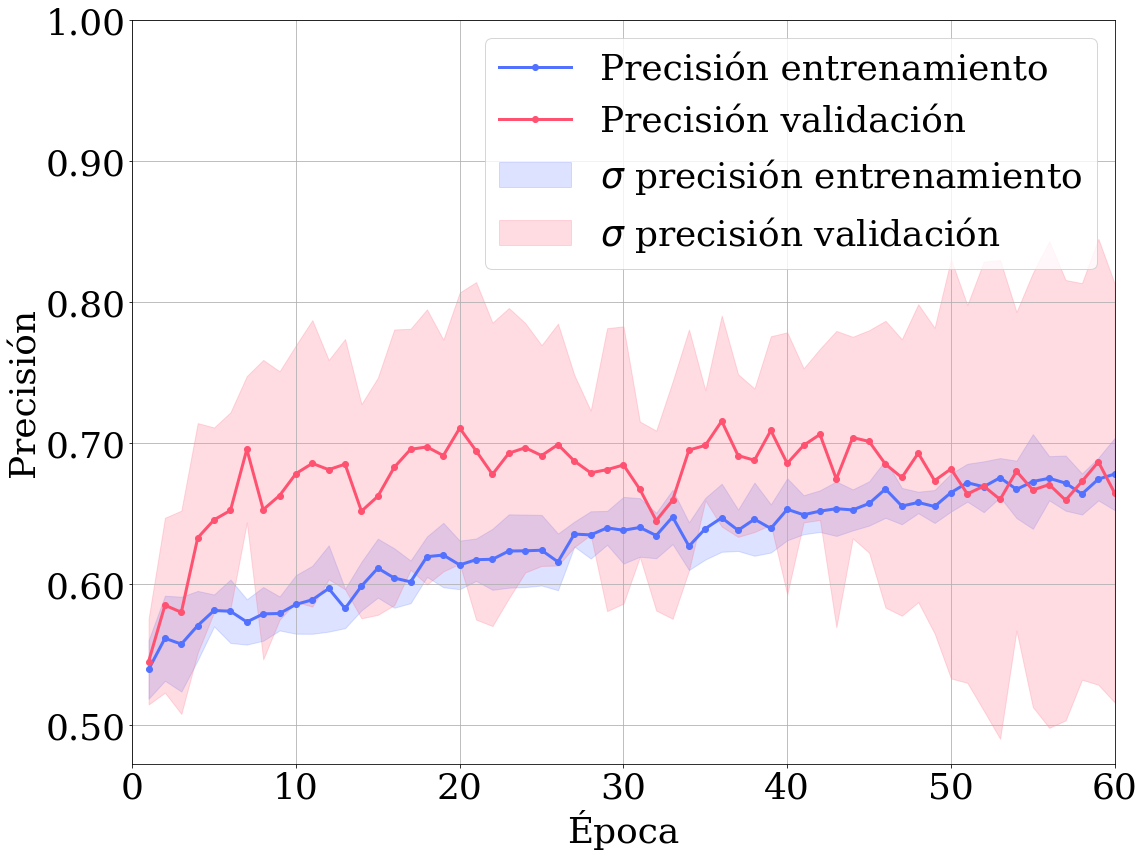

In [ ]:
graphGridAcc(skips)

### Evaluación en test de los modelos

In [ ]:
for skip in skips:
  mean_test = np.mean(resultGeneralDO[skip][5])
  std_test = np.std(resultGeneralDO[skip][5])
  print(f'Modelo {skip}, test {mean_test*100:0.2f} +/- {std_test*100:0.3f}')

Modelo 15, test 66.40 +/- 13.332


### Evaluación en entrenamiento de los modelos

In [ ]:
for skip in skips:
  mean_train = np.mean([resultGeneralDO[skip][0][x][-1] for x in resultGeneralDO[skip][0]])
  std_train = np.std([resultGeneralDO[skip][0][x][-1] for x in resultGeneralDO[skip][0]])
  print(f'Modelo {skip}, train {mean_train*100:0.2f} +/- {std_train*100:0.3f}')

Modelo 15, train 67.80 +/- 2.290
